# 02477 Bayesian Machine Learning - Exercise 2

In [1]:
%matplotlib inline
import pylab as plt
import pandas as pd
import jax.numpy as jnp
from jax import random
import seaborn as snb


from scipy.stats import binom as binom_dist

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.)
colors = 'brgmc'

# Introduction

The purpose of this exercise is to dive deeper into the basic concepts of probabilistic and Bayesian modelling using **logistic regression** as a case-study. Specifically, we will study:

- the probability distributions involved in logistic regression
- how to approximate the posterior distribution of non-conjugate models using simple grid approximations
- how to make predictions using posterior predictive distributions

We will study these concepts using data from Challenger Space Shuttle disaster.


**Content**

- Part 1: Setting up the logistic regression model
- Part 2: The prior, likelihood and posterior
- Part 3: Making predictions using point estimates
- Part 4: Approximating the posterior using a grid approximation
- Part 5: Propagating uncertainty from parameters to predictions



# Dataset: The Challenger Space Shuttle disaster 

On a cold morning on January 28, 1986 the space shuttle called **Challenger** tragically exploded 73 seconds after its launch, killing all 7 crew members. The explosion was later determined to be caused the failure of two out of six so-called o-ring seals in one of the rocket boosters.
The temperature on the day of the launch was close $0^{\circ} C$, which was record-low. The cold weather made the o-rings stiffen, reducing their ability to seal the critical joints, and hence, causing the tragic accident. O-ring failure had previously been observed on 6 of out the 23 prior launches as plotted below.

In this exercise, you will construct a simple Bayesian logistic regression model for predicting the probability of o-ring failure as a function of temperature.

The dataset $\mathcal{D} = \left\lbrace (t_i, y_i) \right\rbrace_{i=1}^{M}$ consists of $M=23$ observations, where $y_i \in \left[0, 1, \dots 6\right]$ denotes the number of failed o-rings for the $i$'th temperature $t_i$. The number of o-rings for all launches were $N = 6$, and hence, the fraction of failed o-rings for the $i$'th launch is $\frac{y_i}{N} = \frac{y_i}{6}$.

See [Wikipedia](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) for more background information.


First, we will load the data:

In [5]:
# load data from csv file uisng pandas
data = pd.read_csv('../o-ring.csv')
t = data['temperature'].values
y = data['failed'].values
N = data['count'].values

data.head()

temperature  failed  count
0    18.888889       0      6
1    21.111111       1      6
2    20.555556       0      6
3    20.000000       0      6
4    19.444444       0      6

.. and plot it:

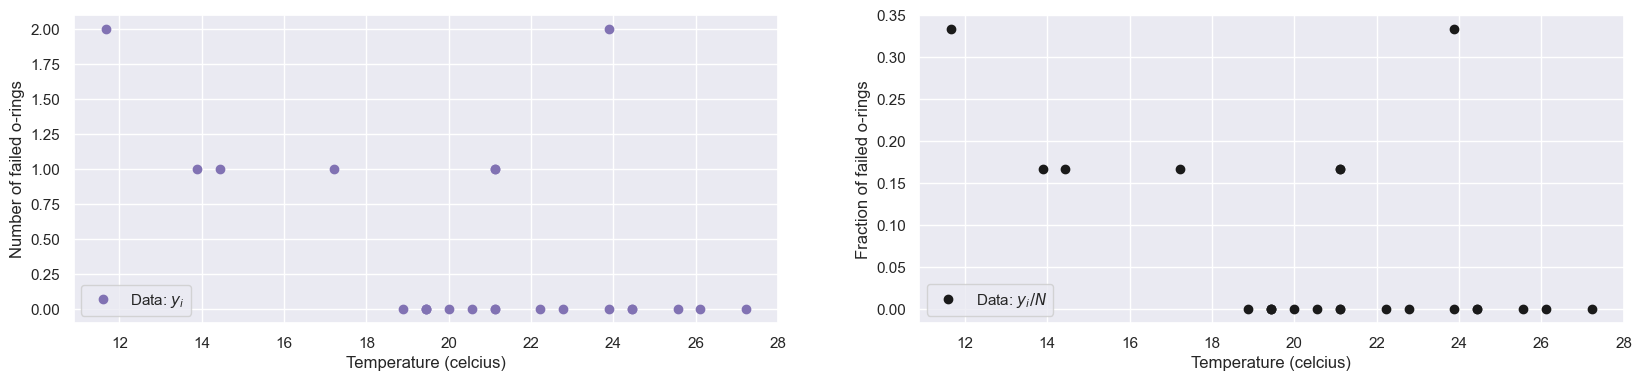

In [6]:
# helper function for plotting data
def plot_data(ax=None, counts=True):
    if counts:
        ax.plot(t, y, 'mo', label='Data: $y_i$')
        ax.set(ylabel='Number of failed o-rings')
    else:
        ax.plot(t, y/N, 'ko', label='Data: $y_i/N$')
        ax.set(ylabel='Fraction of failed o-rings')
    ax.set(xlabel='Temperature (celcius)')
    ax.legend(loc='lower left')

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
plot_data(ax[0])
plot_data(ax[1], counts=False)

Rather than working directly with the temperatures $t_i \in \mathbb{R}$, we will standardize the temperatures to get

$\begin{align*}
x_i = \frac{t_i - t_{\text{mean}}}{t_{\text{std}}},
\end{align*}$
where $t_{\text{mean}}$ and $t_{\text{std}}$ are the empirical mean and standard deviation, respectively, of the observed temperatures $\left\lbrace t_i \right\rbrace_{i=1}^M$.

In [9]:
# compute mean and standard deviation of temperatures
tmean, tstd = jnp.mean(t), jnp.std(t)

# standardize temperatures
standardize = lambda t_: (t_ - tmean)/tstd
x = standardize(t)

# Part 1:  Setting up the logistic regression model

### The big picture

Our goal is to use the training data, i.e. the pairs of $\mathbf{x}_i$ and $y_i$, to learn a model such that we can make predictions and reason about the number of failures $y^*$ for a new input point $x^*$. In probabilistic terms, our goal is to compute $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$. That is, the distribution of the number of failures $y^*$ **conditioned on** the observed data $\mathbf{x}, \mathbf{y}$ as well as the new input point $x^*$. In probabilistic machine learning, we generally refer to $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ as the **posterior predictive distribution**.
Once we computed this distribution, we can use it to reason about $y^*$ and answer questions like:
- What is the expected number of failures?
- What is the most likely number of failures?
- What is the probability that the number of failures is zero?
- What is a 90% interval credibility interval for the number of failures?
_______________


> ##### Bayesian Logistic Regression: From Training Data to Posterior Predictive


##### 1) Our ultimate goal

We want the distribution of a new binary label $y^*$ at a new input $x^*$, given training inputs $\{x_i\}$ and outputs $\{y_i\}$:

$
p\bigl(y^* \mid \mathbf{y}, \mathbf{x}, x^*\bigr).
$

This is called the **posterior predictive** distribution.


##### 2) The parametric model

Introduce a parameter vector $\theta = (w,b)$.  We assume

$
p(y \mid x, \theta)
\;=\;
\mathrm{Bernoulli}\!\bigl(y \mid \sigma(w^\top x + b)\bigr),
$

where $\sigma(a) = \tfrac{1}{1 + e^{-a}}$ is the logistic (“sigmoid”) function.  Concretely, for each data point,

$
p(y_i \mid x_i, \theta)
\;=\;
\sigma\bigl(w^\top x_i + b\bigr)^{y_i}
\bigl(1 - \sigma(w^\top x_i + b)\bigr)^{1-y_i}.
$



##### 3) The parameter posterior

Place a prior $p(\theta)$.  After observing $\{(x_i,y_i)\}_{i=1}^N$, Bayes’ rule gives

$
p(\theta \mid \mathbf{y}, \mathbf{x})
\;\propto\;
p(\theta)\;\prod_{i=1}^N p(y_i \mid x_i, \theta).
$


##### 4) The exact posterior predictive

To predict $y^*$ at $x^*$, average over all $\theta$:

$
p(y^* \mid \mathbf{y}, \mathbf{x}, x^*)
\;=\;
\int
p(y^* \mid x^*, \theta)\;
p(\theta \mid \mathbf{y}, \mathbf{x})\;d\theta.
$

This is exact but generally intractable in high dimensions.


##### 5) The plug-in (classical) approximation

Replace the posterior by a point mass at $\hat\theta$ (e.g. the MLE or MAP):

$
p(\theta \mid \mathbf{y}, \mathbf{x})
\approx
\delta\bigl(\theta - \hat\theta\bigr).
$

Then

$
p(y^* \mid \ldots)
\;\approx\;
p\bigl(y^* \mid x^*, \hat\theta\bigr),
$

which is the standard “fit-then-predict” recipe.


##### 6) Bayesian approximations to the integral

Instead of collapsing to $\hat\theta$, we can approximate the integral in Step 4 by:

1. **Monte Carlo**  
   Draw $\theta^{(s)}\sim p(\theta\mid\mathbf{y},\mathbf{x})$, then  
   $
     p(y^*\mid\ldots) \approx \frac{1}{S}\sum_{s=1}^S p\bigl(y^*\mid x^*,\,\theta^{(s)}\bigr).
   $

2. **Laplace’s method**  
   Approximate the posterior by a Gaussian around its mode, then do the integral analytically.

3. **Grid approximation** (only in very low-dim)  
   Evaluate the unnormalized posterior on a finite grid $\{\theta_k\}$, normalize, and sum.

All of these retain **predictive uncertainty** (e.g. credible intervals on $p(y^*=1)$ or on decision boundaries), unlike the plug-in.

---

**Key takeaway**  
- Logistic regression likelihood: $p(y|x,\theta)=\mathrm{Bernoulli}\bigl(\sigma(w^\top x + b)\bigr)$.  
- Bayesian posterior: $p(\theta|\mathrm{data})\propto p(\theta)\prod_i p(y_i|x_i,\theta)$.  
- Posterior predictive: average over $\theta$.  
- Plug-in is a delta-approximation; Monte Carlo, Laplace, grid give better uncertainty quantification.  



_____________
Before we can compute $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$, we first need to specify a model.

### Specifying the model

For each temperature $x_i$, we know the number of failed o-ring $y_i = \{0, 1, \dots, 6 \}$ out of the total number of o-rings $N_i = 6$. Hence, the number of failing o-rings $y_i$ for a given temperature $x_i$ can be described by a **Binomial distribution** with $N_i = 6$ and probability $\theta_i \in \left[0, 1\right]$: 

$\begin{align}
y_i|\theta_i \sim \text{Bin}(N_i, \theta_i).
\end{align}
$

This is equivalent to modelling the failure of each individual o-ring as **conditionally independent** Bernoullli trials. Since all observations have $N_i = 6$, we drop the subscript $i$ and simply write $N = 6$ in the following to ease the notation.

Rather than imposing Beta-distributions as prior distributions for each $\theta_i$, we assume $\theta_i$ can be modelled as is a function of the temperature. Specifically, we assume

$\begin{align}
\theta(x) = \sigma(\alpha + \beta x),
\end{align}
$

where $\alpha, \beta \in \mathbb{R}$ are parameters to be estimated and $\sigma: \mathbb{R} \rightarrow \left[0, 1\right]$ is the **logistic sigmoid function**, i.e. $\sigma(x) = (1+\exp(-x))^{-1}$. For later references, we will denote the linear component of the model as $f(x)$, i.e.

$\begin{align}
f(x) = \alpha + \beta x.
\end{align}
$
Note that both $\theta(x)$ and $f(x)$ do indeed depend on $\alpha$ and $\beta$, but we suppress this dependency to ease the notation. The likelihood of the $i$'th data point thus becomes
$
\begin{align}
p(y_i|x_i, \alpha, \beta) = \text{Bin}(y_i|N_i, \theta_i),
\end{align}
$
where we have defined $\theta_i \equiv \theta(x_i) = \sigma(\alpha+\beta x_i)$. Assuming that all observations $\left\lbrace y_i \right\rbrace_{i=1}^M$ are **conditionally independent** given $\theta_i$, the likelihood of the full dataset becomes

$\begin{align}
p(\mathbf{y}|\mathbf{x}, \alpha, \beta) = \prod_{i=1}^M p(y_i|x_i, \alpha, \beta) = \prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i),
\end{align}
$

where $\mathbf{y} = [y_1, y_2, \dots, y_M]$ and $\mathbf{x} = [x_1, x_2, \dots, x_M]$. Our goal is to be able to predict $y^*$ for a new temperature $x^*$.  To do this we write down the *predictive likelihood* for $y^*$, i.e.

$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N^*, \theta^*),
\end{align}
$ 

where $\theta^* \equiv \theta(x^*) = \sigma(\alpha + \beta x^*)$. Using the **product rule** and the assumption of conditional independence, we have

$\begin{align}
p(\mathbf{y}, y^*|\mathbf{x}, x^*, \alpha, \beta) = p(\mathbf{y}|\mathbf{x}, \alpha, \beta)p(y^*|x^*, \alpha, \beta) = \underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}.
\end{align}
$

To complete the Bayesian model, we need to impose a prior distribution on the parameters $\alpha, \beta$. Since we do not have any information about the parameters, we will impose generic Gaussian priors with zero mean:

$\begin{align}
p(\alpha, \beta) = \mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta})
\end{align}
$
for $\sigma^2_\alpha, \sigma^2_\beta > 0$. This leads to the following **joint distribution** for $y^*, \mathbf{y}, \alpha,$ and $\beta$:

$\begin{align}
p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*) = p(y^*|x^*, \alpha, \beta)p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta) = \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}\underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta})}_{p(\alpha, \beta)},
\end{align}
$

where we again used the product rule.

The joint distribution is a central object because it completely determines how all variables (e.g. both data and parametes) interact and thus, it completely specifies our probabilistic model. From the joint distribution, we can derive any related distribution of interest using the rules of probability theory. 

### From the joint distribution to the posterior predictive distribution

Because we observe $\mathbf{y}$, we naturally consider the **conditional distribution** of $y^, \alpha, \beta$ given the observed quantities $\mathbf{y}, \mathbf{x}, x^*$. Using the standard rules for condtional distributions, we get:

$\begin{align}
p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) = \frac{p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)}{p(\mathbf{y}|\mathbf{x})}.
\end{align}$

Our primary goal is to compute the **posterior predictive distribution** $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$, i.e. the **marginal distribution** of $y^*$ conditioned on the observed data, i.e. $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ which can be obtained by marginalizing over $\alpha$ and $\beta$ via the **sum rule**:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int\int p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) \text{d} \alpha \text{d}\beta= \int\int \underbrace{p(y^*|x^*, \alpha, \beta)}_{\text{likelihood for }y^*} \underbrace{p(\alpha, \beta|\bm{y}, \bm{x})}_{\text{posterior distribution}} \text{d} \alpha \text{d}\beta,
\end{align}
$
as we derived in the lecture. The last equation shows that we can obtain the posterior predictive distribution by averaging the predictive likelihood wrt. to the posterior distribution. Hence, our first effort will be to get a handle on the posterior distribution of $\alpha$ and $\beta$ conditioned on $\mathbf{y}$.

Before starting the practical implementation, we will practice the terminology and the probabilistic machinery.

**Task 1.1**: Use the **product rule** to write down the joint distribution of $\mathbf{y}, \alpha, $ and $\beta$ given $\mathbf{x}$:

*Hint*: This is meant to be an easy task.

**Solution**

The product rule yields:

$\begin{align*}
p(\mathbf{y}, \alpha, \beta|\mathbf{x}) = p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta)
\end{align*}
$

**End of solution**

**Task 1.2**: Show that $p(\mathbf{y}, \alpha, \beta|\mathbf{x}) = \sum_{y^*}  p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)$, where the sum is over all possible outcomes of $y^*$.

**Solution**

We have
$\begin{align*}
\sum_{y^*}  p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*) &= \sum_{y^*}  p(y^*|x^*, \alpha, \beta)p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta) \tag{Using eq. (9)}\\
&= p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta)\sum_{y^*}  p(y^*|x^*, \alpha, \beta) \tag{linearity of sums}\\
&= p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta)\tag{PMFs sums to 1}\\
&= p(\mathbf{y}, \alpha, \beta|\mathbf{x}) \tag{product rule},
\end{align*}
$
since $\sum_{y^*}  p(y^*|x^*, \alpha, \beta) = 1$.

**End of solution**

**Task 1.3**: Use Bayes' rule to express the posterior $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ in terms of the prior, likelihood and evidence and argue that the posterior is proportional to the joint distribution $p(\mathbf{y}, \alpha, \beta|\mathbf{x})$.

**Solution**

**Bayes' rules** states that

$\begin{align*}
p(\alpha, \beta|\mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta)}{p(\mathbf{y}|\mathbf{x})}
\end{align*}
$

Furthermore, the **evidence** $p(\mathbf{y}|\mathbf{x}) = k$ is constant wrt. both $\alpha$ and $\beta$, and therefore, we get
$\begin{align*}
p(\alpha, \beta|\mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta)}{k} \propto p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta) = p(\mathbf{y}, \alpha, \beta|\mathbf{x})
\end{align*}
$

**End of solution**


_________

# Step-by–Step Explanation of Tasks 1.1–1.3

---

## Task 1.1  
**Write down**  
$
p(\mathbf{y}, \alpha, \beta \,\big|\, \mathbf{x})
$  
using the **product rule**.

### Recall: Product Rule  
For any three random quantities $A,B,C$,
$
p(A, B \mid C) \;=\; p(A \mid B, C)\,p(B\mid C).
$

### Apply to our variables  
Take 
$
A = \mathbf{y}, 
\quad B = (\alpha,\beta), 
\quad C = \mathbf{x}.
$  
Then
$
p(\mathbf{y}, \alpha, \beta \,\big|\, \mathbf{x})
=
p\bigl(\mathbf{y}\,\big|\,\alpha,\beta,\mathbf{x}\bigr)
\;\times\;
p\bigl(\alpha,\beta \,\big|\, \mathbf{x}\bigr).
$

If we assume the prior $p(\alpha,\beta)$ is independent of $\mathbf{x}$, then
$
p(\alpha,\beta \,\big|\, \mathbf{x})
= p(\alpha,\beta).
$

#### Final result for Task 1.1  
$
\boxed{
p(\mathbf{y}, \alpha, \beta \,\big|\, \mathbf{x})
= p\bigl(\mathbf{y}\,\big|\,\alpha,\beta,\mathbf{x}\bigr)\;p(\alpha,\beta).
}
$

---

## Task 1.2  
**Show** that
$
p(\mathbf{y}, \alpha, \beta \,\big|\, \mathbf{x})
\;=\;
\sum_{y^*} 
p(\mathbf{y}, y^*, \alpha, \beta \,\big|\, \mathbf{x}, x^*),
$  
i.e. marginalizing out $y^*$.

### 1) Expand the right‐hand side using the product rule twice  
$
\begin{aligned}
\sum_{y^*} 
p(\mathbf{y}, y^*, \alpha, \beta \,\big|\, \mathbf{x}, x^*)
&=
\sum_{y^*}
p\bigl(y^* \,\big|\, \mathbf{y}, \alpha,\beta, \mathbf{x}, x^*\bigr)
\;p\bigl(\mathbf{y}, \alpha,\beta \,\big|\, \mathbf{x},x^*\bigr).
\end{aligned}
$

But often we assume **conditional independence** of future label $y^*$ given parameters:
$
p\bigl(y^* \mid \mathbf{y}, \alpha,\beta, \mathbf{x}, x^*\bigr)
=
p\bigl(y^* \mid \alpha,\beta, x^*\bigr).
$  
and similarly
$
p\bigl(\mathbf{y}, \alpha,\beta \mid \mathbf{x}, x^*\bigr)
=
p\bigl(\mathbf{y}, \alpha,\beta \mid \mathbf{x}\bigr).
$

Hence
$
\sum_{y^*}
p(\mathbf{y}, y^*, \alpha, \beta \mid \mathbf{x}, x^*)
=
\sum_{y^*}
p\bigl(y^* \mid \alpha,\beta, x^*\bigr)\;
p\bigl(\mathbf{y}, \alpha,\beta \mid \mathbf{x}\bigr).
$

### 2) Factor out terms not depending on $y^*$  
$
= p\bigl(\mathbf{y}, \alpha,\beta \mid \mathbf{x}\bigr)\;
\sum_{y^*} p\bigl(y^* \mid \alpha,\beta, x^*\bigr).
$

### 3) Use normalization of a PMF  
$
\sum_{y^*} p\bigl(y^* \mid \alpha,\beta, x^*\bigr)
= 1.
$

### 4) Conclude  
$
\sum_{y^*} 
p(\mathbf{y}, y^*, \alpha, \beta \mid \mathbf{x}, x^*)
=
p\bigl(\mathbf{y}, \alpha,\beta \mid \mathbf{x}\bigr).
$  

Which is exactly the left‐hand side.

---

## Task 1.3  
**Use Bayes’ rule** to show
$
p(\alpha,\beta \mid \mathbf{y}, \mathbf{x})
\;\propto\;
p(\mathbf{y}, \alpha,\beta \mid \mathbf{x}).
$

### Bayes’ Rule  
$
p(\alpha,\beta \mid \mathbf{y}, \mathbf{x})
=
\frac{
p(\mathbf{y} \mid \alpha,\beta,\mathbf{x})
\;p(\alpha,\beta \mid \mathbf{x})
}{
p(\mathbf{y} \mid \mathbf{x})
}.
$

Again assume $p(\alpha,\beta\mid\mathbf{x})=p(\alpha,\beta)$.  The denominator  
$
p(\mathbf{y}\mid \mathbf{x})
$  
does *not* depend on $\alpha$ or $\beta$ (it’s just a normalizing constant, called the **evidence**).

### Therefore  
$
p(\alpha,\beta \mid \mathbf{y}, \mathbf{x})
\;\propto\;
p(\mathbf{y} \mid \alpha,\beta,\mathbf{x})
\;p(\alpha,\beta).
$

But by Task 1.1, the right‐hand side is exactly
$
p(\mathbf{y}, \alpha,\beta \mid \mathbf{x}).
$

#### Final result for Task 1.3  
$
\boxed{
p(\alpha,\beta \mid \mathbf{y}, \mathbf{x})
\;\propto\;
p(\mathbf{y}, \alpha,\beta \mid \mathbf{x}).
}
$

---

### Summary of Key Points

1. **Product rule** builds a joint from conditional × marginal.  
2. **Marginalization** (sum/integral) over unobserved variables recovers a smaller joint.  
3. **Bayes’ rule** shows the posterior is proportional to prior × likelihood, which is the same as the joint up to a constant.  

___


Think of it as keeping track of three “blocks” of variables:

• θ-block (the parameters α, β)
• data-block (the observed y’s, given x)
• future-block (the unobserved y*, at x*)

1) Writing the joint over observed data and parameters
We want
p(y, α, β | x)
– the probability of seeing our data y and of the model having parameters (α, β), given the inputs x.

By the product rule
p(A,B|C) = p(A|B,C) · p(B|C)
we take A=the data y, B=(α, β), C=x. That gives
p(y, α, β | x)
= p(y | α, β, x) · p(α, β | x).
We normally assume our prior p(α, β) does not depend on x, so that second factor is just the prior p(α, β).

2) Showing marginalizing out y recovers the same joint*
Now imagine you had also included a future label y* at a new input x*. The full joint is
p(y, y*, α, β | x, x*)
By product rule twice (first joint = p(y*|everything)·p(y,α,β|x,x*), then p(y,α,β|x,x*) = p(y|α,β,x)·p(α,β)):
p(y, y*, α, β | x, x*)
= p(y* | α,β,x*) · p(y | α,β,x) · p(α, β).

Because y* is a new draw that depends only on α,β and x*, it doesn’t change how y and α,β relate. If you sum over all possible values of that unobserved y*, you’re effectively “forgetting” y* and you get back exactly
p(y, α, β | x).
Formally
∑{y*} p(y, y*, α, β | x, x*)
= p(y | α,β,x) p(α,β) · ∑{y*} p(y*|α,β,x*)
= p(y|α,β,x) p(α,β) · 1
= p(y,α,β|x).

3) Bayes’ rule and proportionality
Bayes’ rule says
p(α,β | y,x)
= p(y | α,β,x) · p(α,β) ÷ p(y | x).
The denominator p(y|x) is just a number (it doesn’t depend on α or β), so you can say
p(α,β | y,x) ∝ p(y | α,β,x) · p(α,β)
but that product is exactly the joint p(y,α,β|x) we wrote above.

Why it can feel like shuffling
Every time you apply the product rule, you’re just choosing one variable (or block) to “pull out” as a conditional factor, and the rest becomes a marginal. When you marginalize (sum or integrate) out y*, you’re simply removing it from the joint, and because probabilities over all its possibilities sum to one, it disappears cleanly. Finally, Bayes’ rule just re-rewrites p(α,β|y,x) in terms of p(y,α,β|x) divided by the evidence p(y|x).

A simple analogy
• Imagine α, β are the recipe, x is where you cook, y is the dish you end up with.
• p(y,α,β|x) says “the chance I pick recipe α,β and end up with dish y when I cook at x.”
• If I also predict tomorrow’s dish y*, I extend to p(y,y*,α,β|x,x*). If I then say “I don’t care what y* was,” I sum over it and I’m back to p(y,α,β|x).
• Bayes’ rule says “given I’ve tasted y, what’s the chance I actually used recipe α,β?” That’s the joint probability of (y,α,β) divided by the total probability of y under any recipe.

Keep each variable block clear, write down which is conditioned on what step by step, and you’ll never lose track. Good luck on the exam!


_____


# Part 2:  The prior, likelihood and posterior

The goal of this part is to implement code for evaluating the prior, likelihood and posterior distribution. Due to a combination of **numerical precision** and **mathematical convenience**, we will implement functions for evaluating the logarithm of these distributions. 
Below you are given an incomplete implementation of the logistic regression model. Your task is to complete the implementation. The code contains a few sanity checks that will help to detect potential bugs and errors in your code.


**Task 2.1**: Complete the implementation of the functions *f, theta, log_prior* and *log_likelihood* below.

*Hints*:
- *For implementing the log prior, the function log_npdf is handy.*
- *When implementing the log likelihood, you can  either use *scipy.stats.binom* (imported as binom_dist) or you can implement the PMF of the binomial distribution from scratch.*
- *Note that for each function the output must have the same shape as the inputs. That is, if you run log_prior(1, 1), it should return a scalar. If you run log_prior(alpha_vec, beta_vec), where alpha_vec and beta_vec are [10 x 1] arrays, then the results should also be a [10 x 1] array*


In [10]:
# sigmoid function: computes the logistic sigmoid of x.
sigmoid = lambda x: 1. / (1 + jnp.exp(-x))

# Logarithm of the Normal probability density function.
# Used for defining priors on the logistic regression parameters.
# Parameters:
#   x : variable (scalar or array)
#   m : mean of the normal distribution
#   v : variance of the normal distribution
# Returns:
#   log density with the same shape as x.
log_npdf = lambda x, m, v: -(x - m)**2 / (2 * v) - 0.5 * jnp.log(2 * jnp.pi * v)

class LogisticRegression(object):

    def __init__(self, x, y, N, sigma2_alpha=1., sigma2_beta=1.):
        # Data: 
        #   x: input features (any shape)
        #   y: outcomes (e.g., counts)
        #   N: number of trials per observation
        self.x = x 
        self.y = y
        self.N = N

        # Hyperparameters:
        #   sigma2_alpha: variance for the Gaussian prior on alpha
        #   sigma2_beta: variance for the Gaussian prior on beta
        self.sigma2_alpha = sigma2_alpha
        self.sigma2_beta = sigma2_beta

    def f(self, x, alpha, beta):
        """
        Compute the linear function f(x) = alpha + beta * x.
        
        Parameters:
            x     : Input data. Shape: arbitrary.
            alpha : Intercept. Scalar or array (broadcastable with x).
            beta  : Slope. Scalar or array (broadcastable with x).
        
        Returns:
            The linear combination computed element-wise.
            Output shape: same as x.
        """
        return alpha + x * beta

    def theta(self, x, alpha, beta):
        """
        Compute the logistic function theta(x) = sigma(f(x)),
        where sigma() is the sigmoid function.
        
        Parameters:
            x     : Input data. Shape: arbitrary.
            alpha : Intercept. Scalar or array (broadcastable with x).
            beta  : Slope. Scalar or array (broadcastable with x).
        
        Returns:
            Predicted probabilities after applying the sigmoid.
            Output shape: same as x.
        """
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """
        Compute the log-prior for parameters alpha and beta.
        The prior assumes independent Gaussian distributions with zero mean.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log prior density. Output shape: same as alpha and beta.
        """
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """
        Compute the log-likelihood of the observed data given parameters.
        Uses the binomial PMF for each observation and sums over data points.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log-likelihood value(s) with shape compatible with alpha.
            If using arrays for alpha and beta, the likelihood is summed over the last axis.
        """
        # Compute theta for given x, alpha, and beta.
        theta = self.theta(self.x, alpha, beta)
        # Compute the log PMF for a Binomial distribution and sum over the last axis;
        # output shape will be broadcastable with the input parameters.
        log_lik = jnp.sum(binom_dist.logpmf(self.y, self.N, theta), axis=-1, keepdims=True)
        return log_lik

    def log_joint(self, alpha, beta):
        """
        Compute the log joint probability: log p(y, alpha, beta | x),
        which is the sum of the log-prior and the log-likelihood.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log joint density, squeezed to remove any singleton dimensions.
            Output shape depends on the shapes of alpha and beta.
        """
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()
        
    def theta(self, x, alpha, beta):
        """ implements eq. (2). Output must have the same shape as x """
        
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """ implements log. of eq. (8). Output must have the same shape as alpha and beta """
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """ implements log. of eq. (5). Output must have the same shape as alpha and beta """
        theta = self.theta(x, alpha, beta)
        log_lik = jnp.sum(binom_dist.logpmf(self.y, self.N, theta), axis=-1, keepdims=True)
        return log_lik

    def log_joint(self, alpha, beta):
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()
    
# instantiate model
#model = LogisticRegression(x, y, N) 

# some sanity checks to help verify your implementation and make it compatible with the rest of the exercise
#assert jnp.allclose(model.theta(x=2, alpha=2, beta=-0.5), 0.7310585786300049), "The value of output of the theta-function was different than expected. Please check your code."
#assert jnp.allclose(model.log_prior(1., 1.), -2.8378770664093453), "The value of the output of the log_prior function was different than expected. Please check your code."
#assert jnp.allclose(model.log_likelihood(-1.,2.), -95.18926297085957), "The value of the output of the log_likelihood function was different than expected. Please check your code."
#
#assert model.theta(jnp.linspace(-3, 3, 10), 1, 1).shape == (10,), "The shape of the output of the theta-function was different than expected. Please check your code."
#assert model.log_prior(jnp.linspace(-3, 3, 10), jnp.linspace(-3, 3, 10)).shape == (10,), "The shape of the output of the log_prior-function was different than expected. Please check your code."
#assert model.log_likelihood(jnp.linspace(-3, 3, 10)[:, None], jnp.linspace(-3, 3, 10)[:, None]).shape == (10, 1),  "The shape of the output of the log_likelihood-function was different than expected. Please check your code."


In [13]:
# testing the class 
model_ = LogisticRegression(x, y, N,
                           sigma2_alpha=1.0,   # prior variance on intercept
                           sigma2_beta=1.0)    # prior variance on slope


# the p values return probabilities of failure for each temperature input 
p_ = model.theta(x, 1.0, 1.0)
# p will have the same shape as x
print(f"p values: {p_}")
print(f"p.shape: {p_.shape}")

print("*" * 50)

# log prior
lp = model.log_prior(1.0, 1.0)
# lp.shape matches alpha.shape (and beta.shape)
print(f"lp values: {lp}")
print(f"lp shape {lp.shape}")

print("*" * 50)

ll = model.log_likelihood(1.0, 1.0)
# if alpha, beta are scalars, ll.shape == (1,)
# if alpha, beta are arrays of length M, ll.shape == (M,1)
print(f"log likelihood values {ll}")
print(f"log likelihood {ll.shape}")

print("*" * 50)

lj = model.log_joint(1.0, 1.0)
# squeezes away that trailing singleton, so
# shape == () if alpha, beta scalars
# shape == (M,) if alpha, beta arrays of length M
print(f"log joint values {lj}")
print(f"log joint {lj.shape}")

print("*" * 50)

p values: [0.61856186 0.74326223 0.7146563  0.6842173  0.65211177 0.79458153
 0.8172242  0.74326223 0.30565137 0.5121948  0.74326223 0.90221524
 0.65211177 0.1978043  0.65211177 0.85661143 0.74326223 0.9344254
 0.8735052  0.91427374 0.85661143 0.8735052  0.3372345 ]
p.shape: (23,)
**************************************************
lp values: -2.837877035140991
lp shape ()
**************************************************
log likelihood values [-179.167]
log likelihood (1,)
**************************************************
log joint values -182.0048828125
log joint ()
**************************************************


If the model implementation above is correct, then the code below should produce contour plots of the prior, likelihood and posterior. We also compute and plot the MLE and MAP estimators for the model. Because this is a 2D problem, we can simply obtain the MLE/MAP estimators by maximizing over the set of grid values. However, this becomes infeasible in higher dimensions, where gradient-based optimization is used instead.

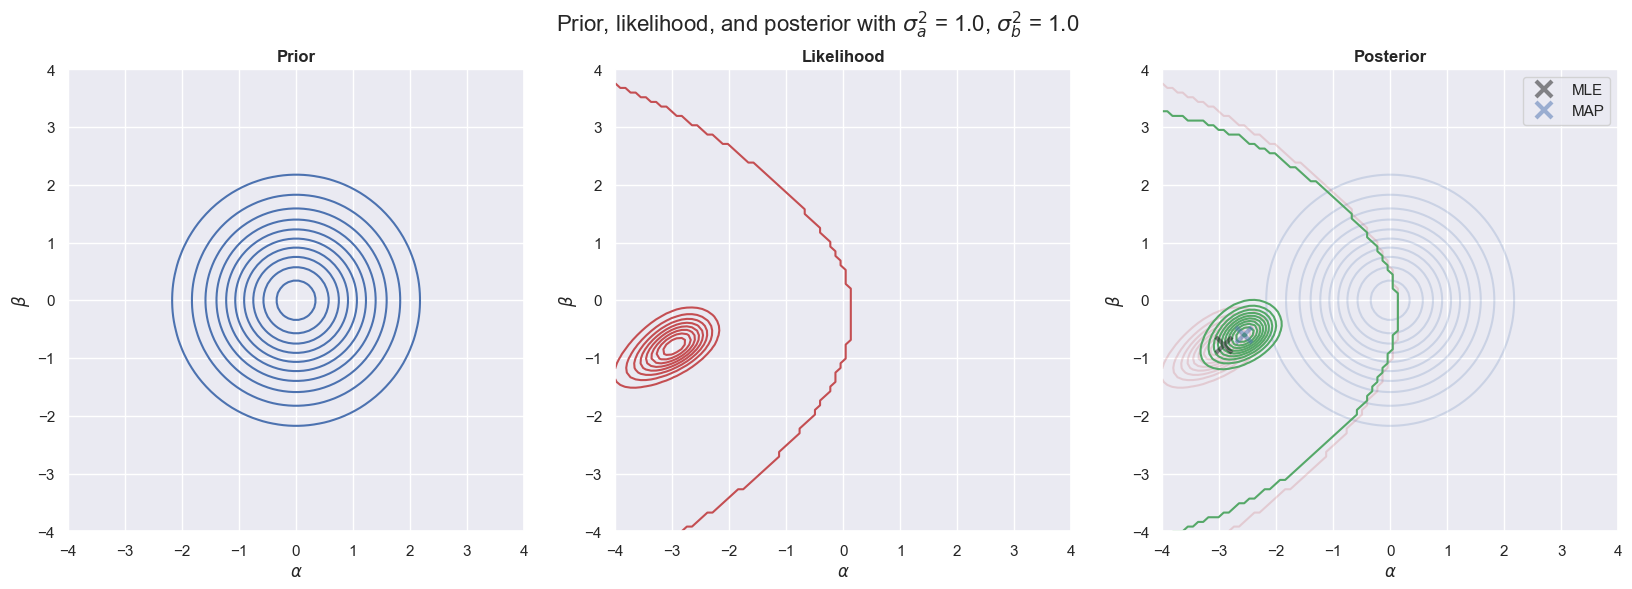

In [14]:
class Grid2D(object):
    """
    Helper class for evaluating a function on a 2D grid defined by (alpha, beta).
    """

    def __init__(self, alphas, betas, func, name="Grid2D"):
        """
        Initialize the Grid2D object.

        Parameters:
            alphas: 1D array of shape (num_alpha,)
                Grid values for alpha.
            betas: 1D array of shape (num_beta,)
                Grid values for beta.
            func: callable
                Function to evaluate on the grid. Should accept (alpha, beta) arrays of shape (num_alpha, num_beta, 1)
                and return an array of shape (num_alpha, num_beta, 1) or (num_alpha, num_beta).
            name: str
                Name for the grid (used in plotting).
        """
        self.alphas = alphas  # shape: (num_alpha,)
        self.betas = betas    # shape: (num_beta,)
        self.grid_size = (len(self.alphas), len(self.betas))  # (num_alpha, num_beta)
        # Create meshgrid for alpha and beta, both shape: (num_alpha, num_beta)
        self.alpha_grid, self.beta_grid = jnp.meshgrid(alphas, betas, indexing='ij')
        self.func = func
        self.name = name

        # Evaluate func on the grid. Inputs to func: (num_alpha, num_beta, 1)
        # Output: (num_alpha, num_beta, 1) or (num_alpha, num_beta)
        self.values = self.func(self.alpha_grid[:, :, None], self.beta_grid[:, :, None]).squeeze()
        # self.values shape: (num_alpha, num_beta)

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        """
        Plot contour lines for the function evaluated on the grid.

        Parameters:
            ax: matplotlib axis
                Axis to plot on.
            color: str
                Color of the contour lines.
            num_contours: int
                Number of contour levels.
            f: callable
                Transformation applied to self.values before plotting (e.g., jnp.exp).
                Input shape: (num_alpha, num_beta), Output shape: (num_alpha, num_beta)
            alpha: float
                Transparency of contour lines.
            title: str or None
                Optional title for the plot.
        """
        # ax.contour expects X, Y, Z all shape (num_alpha, num_beta)
        # .T is used to match orientation
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(self.name, fontweight='bold')

    @property
    def argmax(self):
        """
        Return the alpha and beta values corresponding to the maximum value in the grid.

        Returns:
            (alpha, beta): tuple of floats
                The (alpha, beta) pair where self.values is maximized.
        """
        idx = jnp.argmax(self.values)  # scalar index in flattened array
        alpha_idx, beta_idx = jnp.unravel_index(idx, self.grid_size)  # tuple of ints
        return self.alphas[alpha_idx], self.betas[beta_idx]  # both scalars

# --- Usage Example ---

SIGMA2_ALPHA = 1.0
SIGMA2_BETA = 1.0

# Define grid points for alpha and beta.
# alphas: (num_alpha,), betas: (num_beta,)
num_alpha, num_beta = 90, 100
alphas = jnp.linspace(-4, 4, num_alpha)
betas = jnp.linspace(-4, 4, num_beta)

# Instantiate the logistic regression model with the given data and priors.
# model: LogisticRegression object, expects x, y, N, sigma2_alpha, sigma2_beta
model = LogisticRegression(x, y, N, sigma2_alpha=SIGMA2_ALPHA, sigma2_beta=SIGMA2_BETA)

# Evaluate log prior, log likelihood, and log joint (posterior) over the (alpha, beta)-grid.
# Each Grid2D object evaluates the function on the grid:
# log_prior_grid.values, log_lik_grid.values, log_joint_grid.values: (num_alpha, num_beta)
log_prior_grid = Grid2D(alphas, betas, model.log_prior, 'Prior')
log_lik_grid = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood')
log_joint_grid = Grid2D(alphas, betas, model.log_joint, 'Posterior')

# Create a figure with 3 subplots for Prior, Likelihood, and Posterior contours.
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Overlay the prior (blue) and likelihood (red) contours on the Posterior plot (third subplot)
log_prior_grid.plot_contours(ax[2], f=jnp.exp, color='b', alpha=0.2)
log_lik_grid.plot_contours(ax[2], f=jnp.exp, color='r', alpha=0.2)

# Plot individual contour plots for prior, likelihood, and posterior on separate subplots.
for idx_plot, grid in enumerate([log_prior_grid, log_lik_grid, log_joint_grid]):
    grid.plot_contours(ax[idx_plot], f=jnp.exp, color=colors[idx_plot])

# Compute the MLE estimator from the likelihood grid.
# alpha_MLE, beta_MLE: scalars
alpha_MLE, beta_MLE = log_lik_grid.argmax
# Compute the MAP estimator from the posterior grid.
alpha_MAP, beta_MAP = log_joint_grid.argmax

# Mark the MLE (red x) and MAP (green x) on the Posterior plot.
plt.suptitle(rf"Prior, likelihood, and posterior with $\sigma^2_a$ = {model.sigma2_alpha}, $\sigma^2_b$ = {model.sigma2_beta}", fontsize=16)
ax[2].plot(alpha_MLE, beta_MLE, 'kx', label='MLE', markersize=12, markeredgewidth=3, alpha=0.5)
ax[2].plot(alpha_MAP, beta_MAP, 'bx', label='MAP', markersize=12, markeredgewidth=3, alpha=0.5)
ax[2].legend();
plt.show()


**Task 2.2**: When plotting the contours of the posterior distribution, we actually evaluate the joint distribution and not the posterior distribution . Why is this okay when making contour plots?

**Solution**

Bayes' rule state that the posterior is proportional to the joint distribution. That is, $p(\alpha, \beta|\mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta)}{p(\mathbf{y}|\mathbf{x})} \propto p(\mathbf{y}|\alpha, \beta, \mathbf{x})p(\alpha, \beta)$ because the evidence $p(\mathbf{y}|\mathbf{x})$ is constant wrt. $\alpha$ and $\beta$ and hence does not affect the contour plots.

**End of solution**

____






> **Task 2.3**: Use the code above to experiment and investigate the relationship between the prior, likelihood and posterior. What happens if you change the prior variances of $\alpha, \beta$? E.g. $\sigma^2_{\alpha} = \sigma^2_{\beta} = 10$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 100$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 0.1$? What happens if $\sigma^2_\alpha = 1$ and $\sigma^2_{\beta} = 10$?



### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 1.0$

- We oberve that the **Prior** us inuform, centered at zero (and is Circular Gaussian)
- The **Likelihood** is a highly skewed around (-3, -1) 
- The **posterior** combines the information of prior and likelihood 
    - We see that the posterior is a combination of the prior and likelihood.
    - The prior pulls the likelihood towards 0, but the likelihood pulls the posterior towards the region where the likelihood is large.
- MLE is where the likelihood function is maximized, ignoring the prior. 
- MAP is where is where the posterior is maximized, taking the prior into account.
    - Since the prior is uniform, MAP is closer to the likelihood than the MLE, but still influenced by the prior.

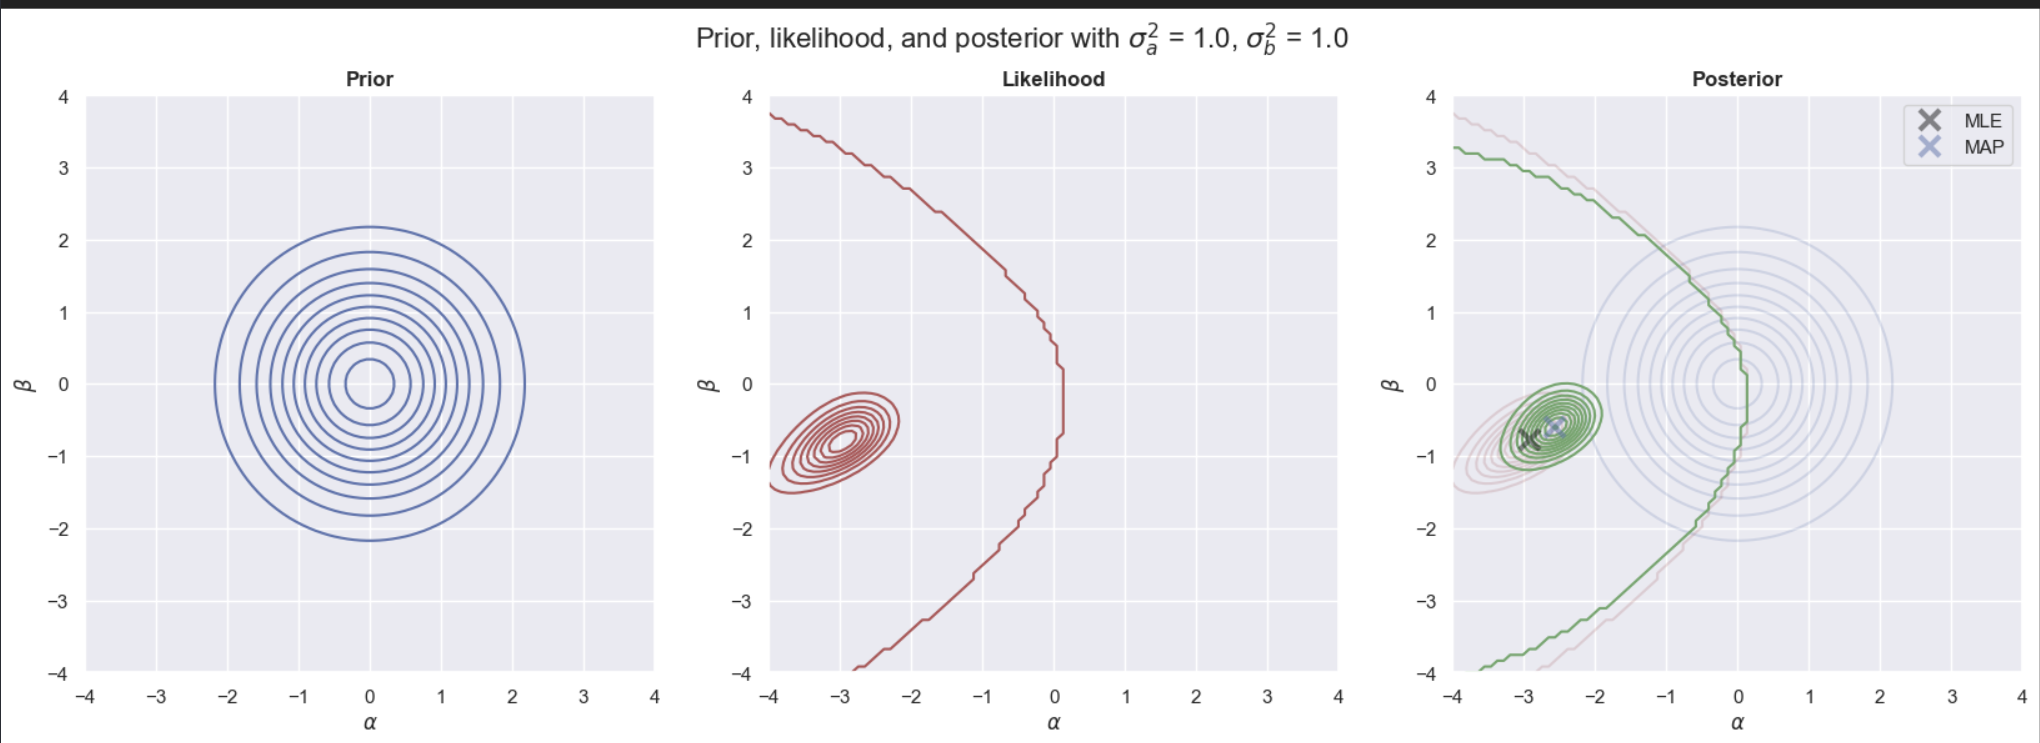
______
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 10.0$
- The **prior** is now more spread out. 
    - This indicates tha the prior is now less informative, and the likelihood will have a larger impact on the posterior.
- The **likelihood** is the same as before (as it is determined by the data).
- The **posterior** is now more influenced by the likelihood than the prior, the prior is very weak and the posterior is 
nearly same as the likelihood. 
- The **MAP** is now closer to the MLE

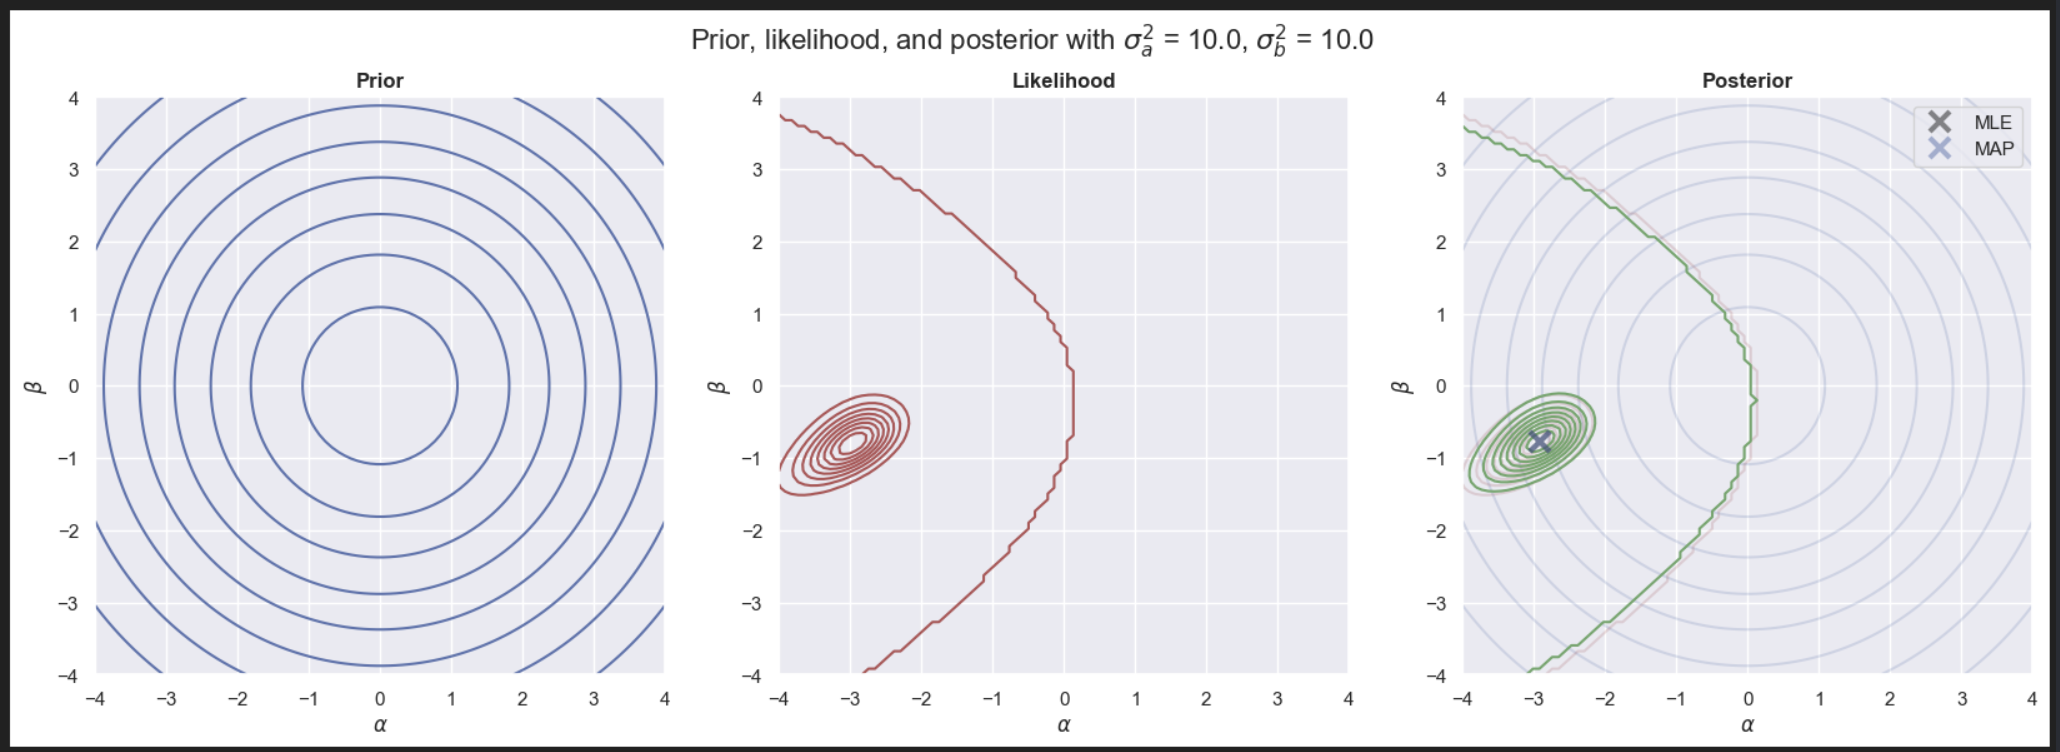

______

### $\sigma^2_{alpha} = 100., \sigma^2_{beta} = 100.0$
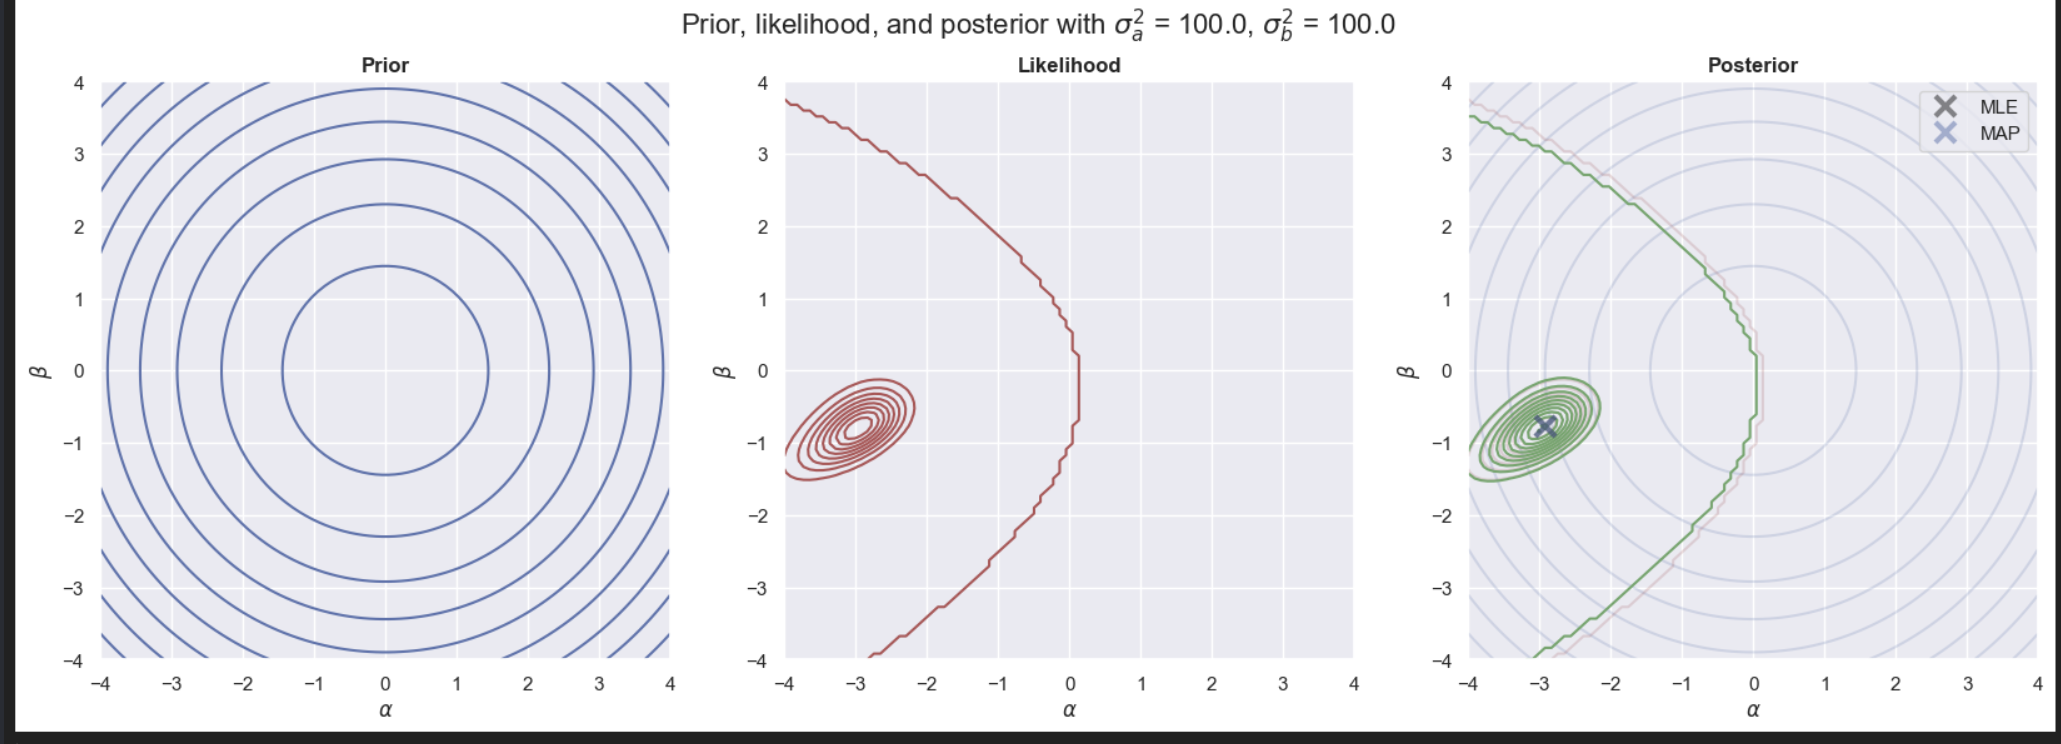

This is just more extreme version of the previous case. The prior is even weaker, and the posterior is nearly the same as the likelihood. The MAP is nearly the same as the MLE.
______
### $\sigma^2_{alpha} = 0.1, \sigma^2_{beta} = 0.1$
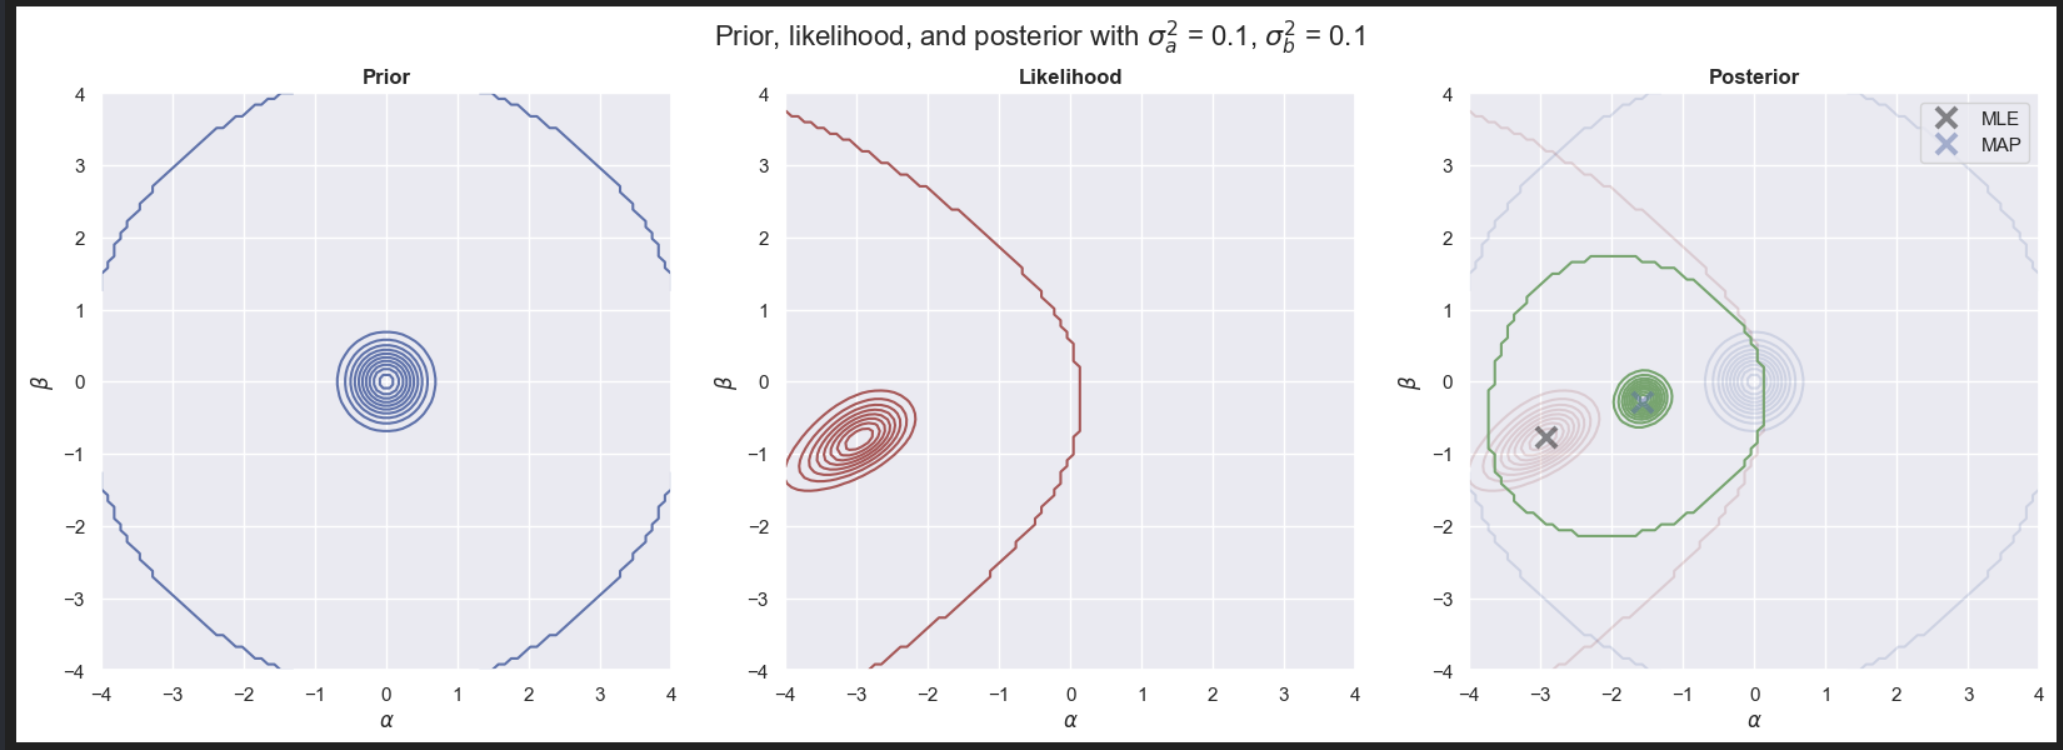


- The **prior** is now more concentrated around zero. 
    - This indicates that the prior is now more informative, and the prior will have a larger impact on the posterior.
- The **likelihood** is the same as before (as it is determined by the data). Very different from the prior.
- The **posterior** is now more influenced by the prior than the likelihood, the prior is very strong and the posterior is therefore pulled towards the prior.
- The **MAP** is now closer to the prior mean than the MLE, it is balanced between the prior and the likelihood.
- The **MLE** is where the likelihood function is maximized, ignoring the prior.
______

### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 10.0$
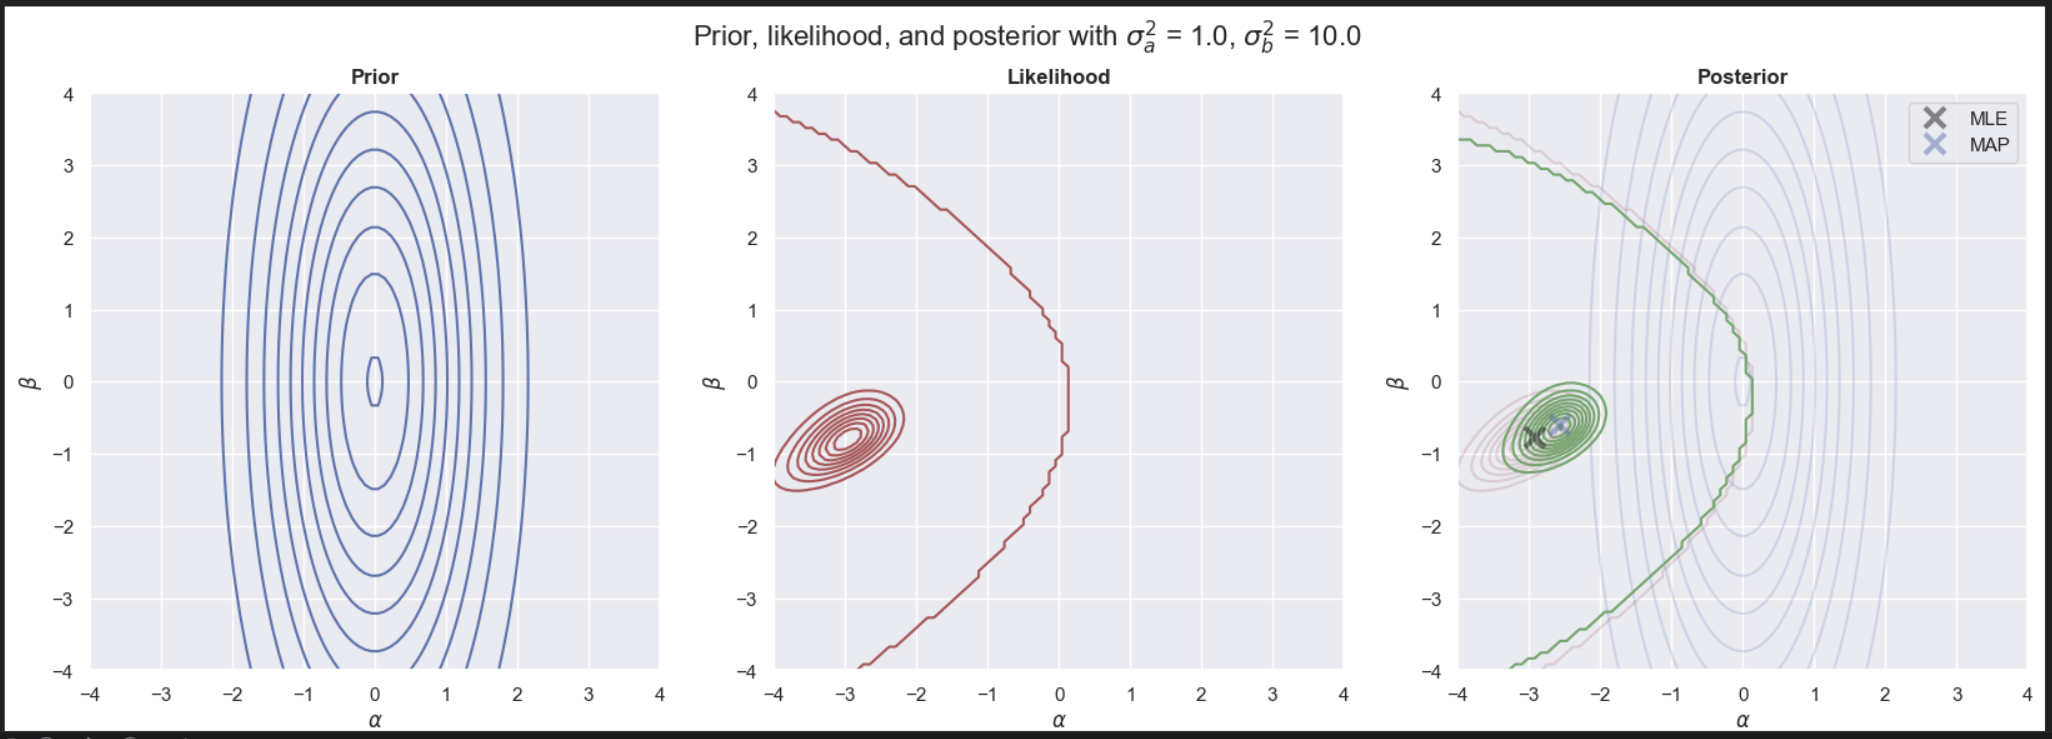

- The prior is now anisotropic  (different variance for alpha and beta). The prior is more informative for beta than for alpha. 
    - The prior is more confident in in the value of alpha than beta.
- The likelihood is the same as before (as it is determined by the data). Very different from the prior.
- The posterior is now a balance between the stronger prior on alpha and the weaker prior on beta.
    - Since the prior is more **restrictive along $\alpha$, the posterior is shifted closer to 0 along the $\alpha$ axis.
    - Since the prior is **weaker along $\beta$**, the posterior is closer to the likelihood along the $\beta$ axis.

______

### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 1.0$
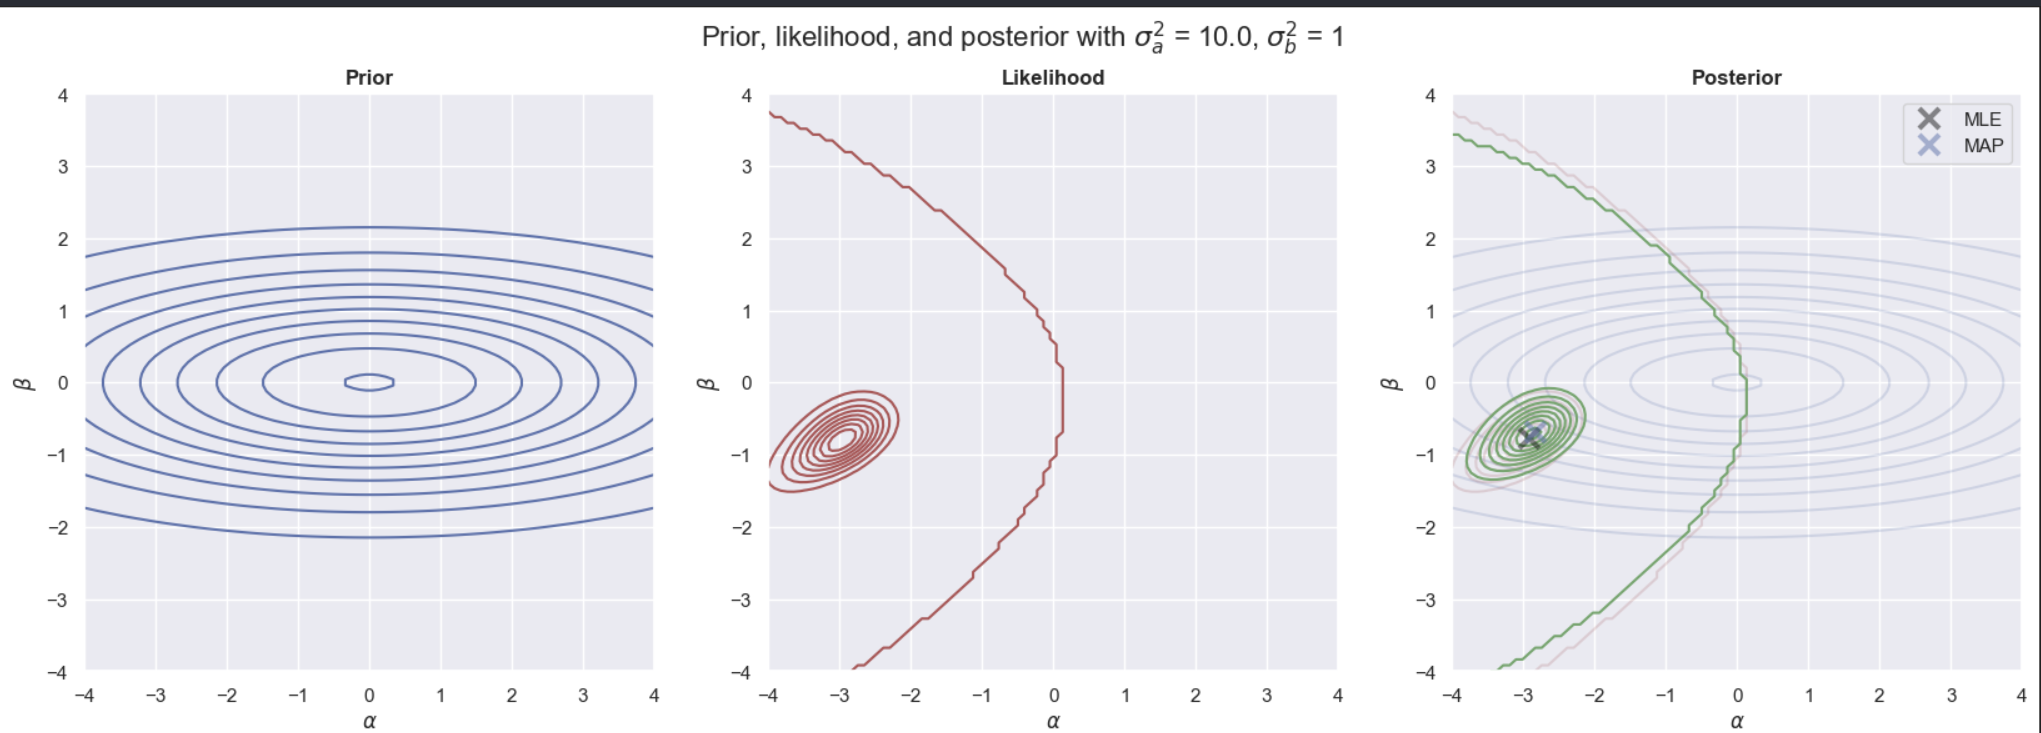
- The **prior** is stretches along the $\alpha$ axis, indicating that we are less confident in the value of $\alpha$ than $\beta$.
    - However, it is tighter along the $\beta$ axis, indicating that we are more confident in the value of $\beta$, being closer to 0.
- The **likelihood** is the same as before (as it is determined by the data). Very different from the prior.
- The **posterior** is now a balance between the stronger prior on beta and the weaker prior on alpha.
    - Since the prior is more **restrictive along $\beta$, the posterior is shifted closer to 0 along the $\beta$ axis.
    - Since the prior is **weaker along $\alpha$**, the posterior is closer to the likelihood along the $\alpha$ axis.





_____



> **Task 2.4**: What happens to the MLE and MAP estimators when you change the variances of the prior?




**MLE** 
- *Definition*: The MLE is the parameter value that maximizes the likelihood function, which depends on the observed data.
- *Effect of changing the prior variance: 
    - The MLE does not change when the prior variance is modified, because it is independent of the prior.
    - It is always located at the maximum of the likelihood function.

**MAP**
- *Definition*: The MAP is the parameter value that maximizes the posterior distribution, which is the product of the likelihood and the prior.
- Effect of changing the prior variance: 
    - *Low prior variance (strong prior)*
        - The MAP is closer to the prior mean than the MLE.
        - The prior has a strong influence on the posterior, pulling the MAP towards the prior mean.
    - *High prior variance (weak prior)*
        - The MAP is closer to the MLE.
        - The prior has a weak influence on the posterior, and the MAP is closer to the MLE.


Summary table of the effect of changing the prior variance on the posterior distribution and the MLE/MAP estimators:

| Prior Variance | Posterior Distribution | MLE | MAP |
|----------------|------------------------|-----|-----|
| Low            | Prior has strong influence on posterior | MAP is closer to prior mean | MAP is closer to prior mean |
| Moderate       | Prior has moderate influence on posterior | MAP is closer to prior mean | MAP is closer to prior mean |
| High           | Prior has weak influence on posterior | MAP is closer to MLE | MAP is closer to MLE |



__________




**Task 2.5**: What happens to the prior, likelihood and posterior if you only use a subset of the data? Use the code above to experiment and investigate what happens, e.g. use the first 10 data instead of the full $M = 23$ datapoints.

### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 1.0$
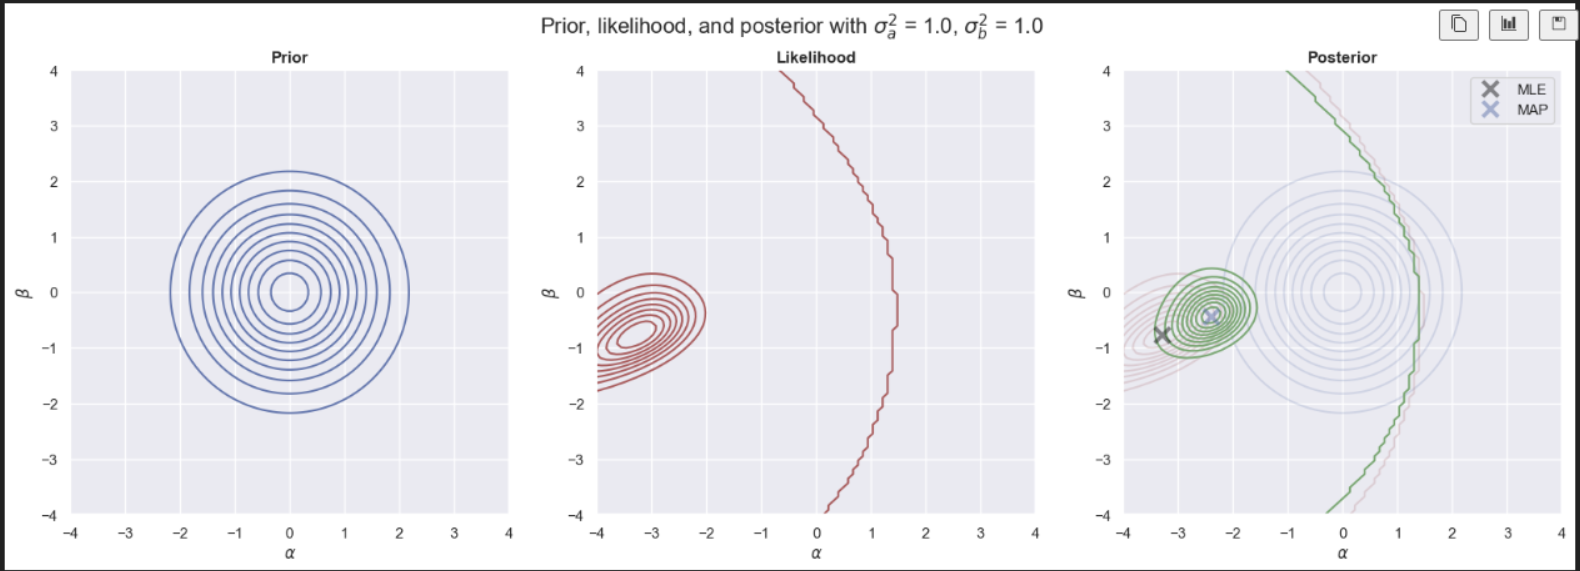
- Prior is uniform, centered at zero. (More or less the same as before in 2.3)
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is a combination of the prior and likelihood, but the prior has a stronger influence on the posterior, since the likelihood is less certain.
- MLE is where the likelihood function is maximized, ignoring the prior.
- MAP is closer to the prior mean compared to the full-data case.
    - Since the likelihood is weaker, the prior’s effect is stronger.
    - If you further reduce the dataset, MAP will continue to shift toward (0,0).
_____
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 10.0$
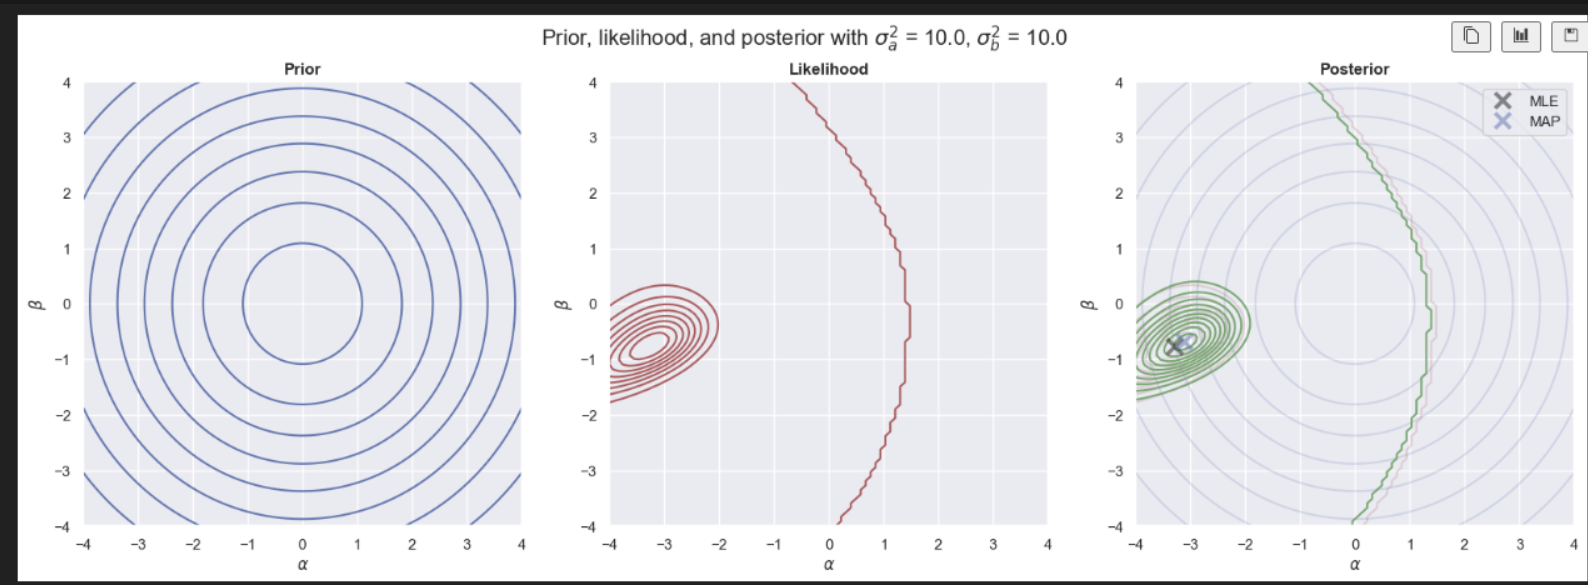
- Prior is more spread out, indicating that we are less certain about the prior.
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is very uncertain, as we have very weak likelihood. 
    - However, since the prior is also weak, it does not significantly pull the posterior toward (0,0).
    - The posterior remains close to the likelihood function, meaning MAP ≈ MLE, but with slightly more smoothing due to the prior.
MAP is very close to MLE, because: The prior is weak ( $\sigma^2 = 10$), so it does not shift the estimate much.
The likelihood function is weak (due to fewer data points), so both estimates have higher uncertainty.
______
### $\sigma^2_{alpha} = 0.1, \sigma^2_{beta} = 0.1$
- Prior is more concentrated around zero, indicating that we are more certain about the prior.
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is a combination of the prior and likelihood, but the prior has a stronger influence on the posterior, since the likelihood is less certain.
    - We can observe that the posterior no longer follows the likelihood, but is strongly influenced by the prior.

- MLE is where the likelihood function is maximized, ignoring the prior.
- MAP is closer to the prior mean compared to the full-data case.
    - Since the likelihood is weaker, the prior’s effect is stronger.
    - If you further reduce the dataset, MAP will continue to shift toward (0,0).

____
### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 10.0$
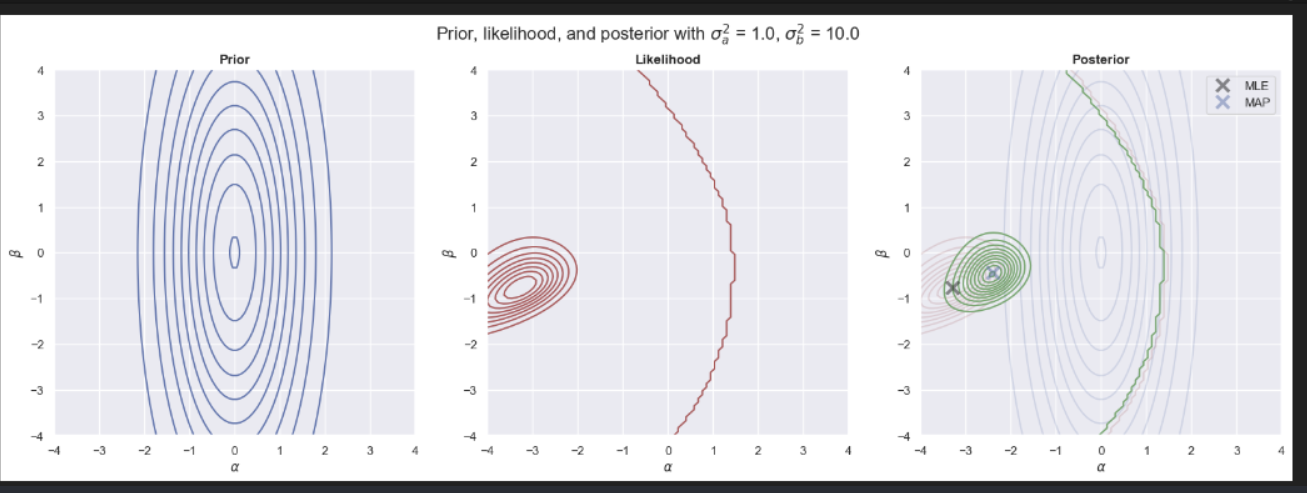
- Very similar as before
-
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 1.0$
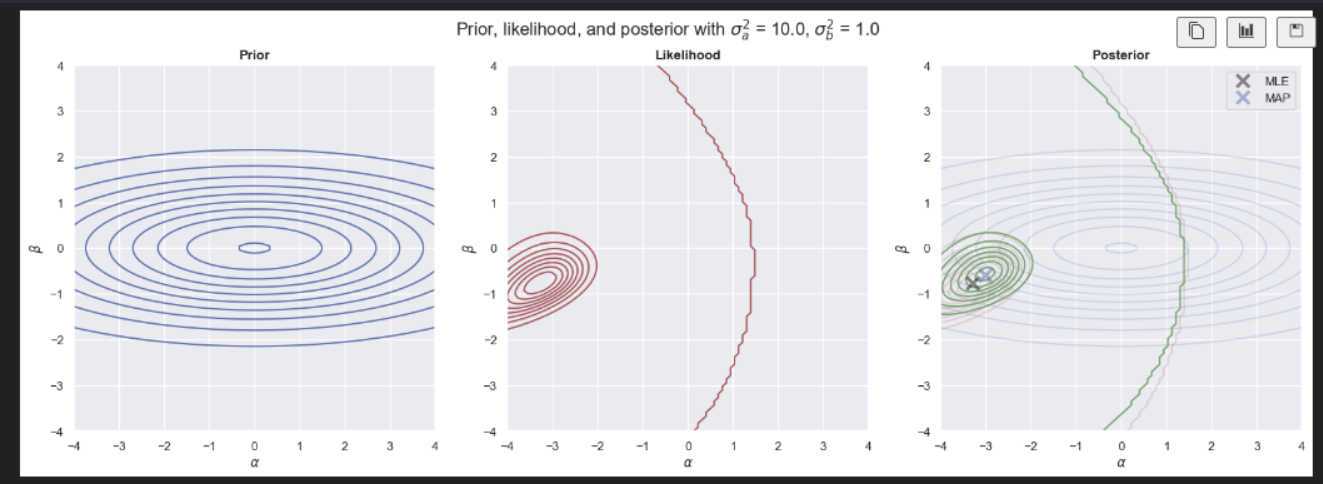
- Very similar as before

_____

**Task 2.6**: Use the plots to roughly estimate the prior and posterior probability of the event $\beta < 0 $.

**Solution**

The prior distribution is symmetric around $(\alpha, \beta) = (0,0)$ as seen in the leftmost plot, and hence, the probability of $\beta < 0$ is 0.5:
$p(\beta <0) = 0.5.$

By inspecting the rightmost plot, we see that most of the posterior mass is below the line $\beta=0$, and hence, we expect the posterior probability of $\beta < 0$ to be close to one:
$p(\beta <0|\mathbf{y}) \approx 1.$

**End of solution**

_______________________-

# Part 3:  Making predictions using point estimates

> Described in the obsidian lecture note for exercises 

Our model for the probability of failure for each individual o-ring is given by

$\begin{align*}
\theta(x) = \sigma(\alpha + \beta x),
\end{align*}
$

where $\alpha, \beta \in \mathbb{R}$ are unknown parameters. Since we do not know the values of the parameters, we can **estimate** them from the data in several ways. The simplest way is via the maximum likelihood estimator (MLE). That is, picking the **point**  that maximizes the likelihood of the data:

$\begin{align*}
\hat{\alpha}_{\text{MLE}}, \hat{\beta}_{\text{MLE}} = \arg\max_{\alpha, \beta \in \mathbb{R}} p(\mathbf{y}|\mathbf{x}, \alpha, \beta).
\end{align*}
$

In practice, we most often due this using gradient-based optimization. However, in this exercise, we will simply pick the parameters values that maximizes the likelihood function on the grid, which works well for 2D problems. Instead of using the MLE, we can also use the Maximum a posteriori (MAP) estimator. That is, picking the **point** that maximizes the posterior distribution:

$\begin{align*}
\hat{\alpha}_{\text{MAP}}, \hat{\beta}_{\text{MAP}} = \arg\max_{\alpha, \beta} p(\alpha, \beta|\mathbf{y},\mathbf{x}).
\end{align*}
$





After obtaining an estimate of the parameters, we can use a **plugin approximation** for $\theta(x)$ by simply inserting the **point estimate** (e.g. MLE or MAP) for $\alpha$ and $\beta$:
$\begin{align*}
\hat{\theta}(x) = \sigma(\hat{\alpha} + \hat{\beta} x),
\end{align*}
$

and then use $\hat{\theta}$ for making predictions.


**Task 3.1**: Compute and plot the predicted probability $\hat{\theta}(x)$ for $x$ corresponding to temperatures $t \in \left[-10, 40\right]$ for both MLE and MAP estimators.


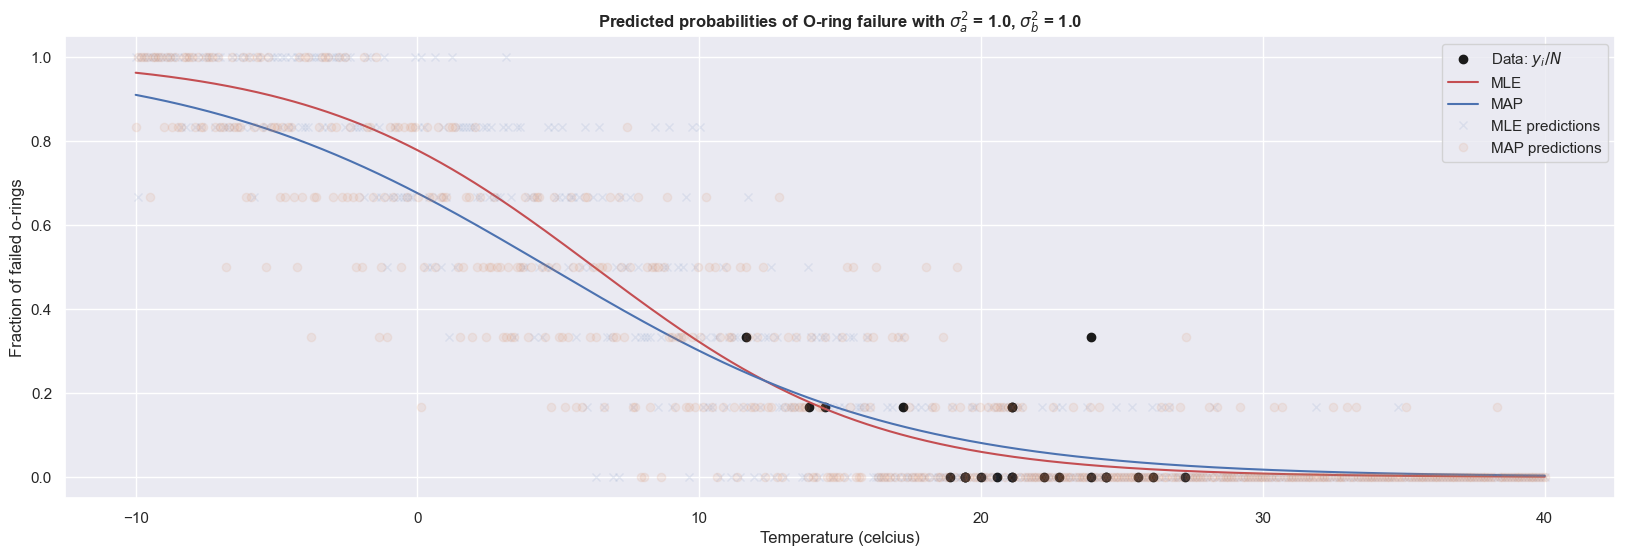

In [18]:
# Generate 500 temperature points from -10 to 40 degrees Celsius for prediction
# Input: None
# Output: temp_pred.shape = (500,)
temp_pred = jnp.linspace(-10, 40, 500)

# Standardize the temperature predictions using the already defined standardization (with tmean and tstd)
# Equation: x_pred = (temp_pred - tmean) / tstd
# Input: temp_pred.shape = (500,), tmean (scalar), tstd (scalar)
# Output: x_pred.shape = (500,)
x_pred = standardize(temp_pred)

# Set the number of trials per prediction (e.g., number of o-rings tested)
# Input/Output: N_pred is scalar
N_pred = 6

# Predict probabilities (theta) using the MAP parameter estimates
# Equation: theta_MAP = sigmoid(alpha_MAP + beta_MAP * x_pred)
# Input: x_pred.shape = (500,), alpha_MAP (scalar), beta_MAP (scalar)
# Output: theta_MAP.shape = (500,)
theta_MAP = model.theta(x_pred, alpha_MAP, beta_MAP)

# Predict probabilities (theta) using the MLE parameter estimates
# Equation: theta_MLE = sigmoid(alpha_MLE + beta_MLE * x_pred)
# Input: x_pred.shape = (500,), alpha_MLE (scalar), beta_MLE (scalar)
# Output: theta_MLE.shape = (500,)
theta_MLE = model.theta(x_pred, alpha_MLE, beta_MLE)

# Simulate binomial outcomes based on the predicted probabilities and number of trials
# Equation: y_pred ~ Binomial(N_pred, theta)
# Input: N_pred (scalar), theta_MAP.shape = (500,), theta_MLE.shape = (500,)
# Output: y_pred_MAP.shape = (500,), y_pred_MLE.shape = (500,)
y_pred_MAP = binom_dist.rvs(N_pred, theta_MAP)
y_pred_MLE = binom_dist.rvs(N_pred, theta_MLE)

# Create a figure for plotting predictions
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Plot the observed data (using a helper function 'plot_data', counts set to False for probability scale)
plot_data(ax, counts=False)

# Plot the continuous prediction from MLE (in red) on the temperature scale
# Input: temp_pred.shape = (500,), theta_MLE.shape = (500,)
ax.plot(temp_pred, theta_MLE, 'r-', label='MLE')

# Set the title for the plot
ax.set_title(rf'Predicted probabilities of O-ring failure with $\sigma^2_a$ = {model.sigma2_alpha}, $\sigma^2_b$ = {model.sigma2_beta}', fontweight='bold')

# Plot the continuous prediction from MAP (in blue)
# Input: temp_pred.shape = (500,), theta_MAP.shape = (500,)
ax.plot(temp_pred, theta_MAP, 'b-', label='MAP')

# Overlay individual simulated predictions for MLE and MAP (normalized by N_pred)
# Input: temp_pred.shape = (500,), y_pred_MLE.shape = (500,), y_pred_MAP.shape = (500,)
ax.plot(temp_pred, y_pred_MLE / N_pred, 'x', label='MLE predictions', alpha=0.1)
ax.plot(temp_pred, y_pred_MAP / N_pred, 'o', label='MAP predictions', alpha=0.1)

# Display the legend on the plot
ax.legend()
plt.show()


**End of solution**


# Part 4:  Approximating the posterior using a grid approximation

Rather than using point estimates, we will now turn to full Bayesian inference to be able to properly reason above the uncertainty of both parameters and predictions. In contrast to the Beta-binomial model, the logistic regression model is **not a conjugate model**, which means we cannot compute the posterior distribution $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ analytically. Instead, we will use a very simple **grid approximation** $q(\alpha, \beta)$ to represent the posterior distribution:

$\begin{align*}
p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \approx q(\alpha, \beta).
\end{align*}
$

To construct the grid approximation $q(\alpha, \beta)$, we need three steps:

1) **Define grid**: First we need to the define grid for $(\alpha, \beta)$. Typically, we choose an appropriate discrete set of values for $\alpha$ and $\beta$ individually, i.e. $\left\lbrace \alpha_i \right\rbrace_{i=1}^I$ and $\left\lbrace \beta_i \right\rbrace_{j=1}^J$, and then take the $(\alpha, \beta)$-grid to be the Cartesian product.

2) **Evaluation:** Next, we need to evaluate the function $p(\alpha, \beta| \mathbf{y, x})$ on each point in the $(\alpha, \beta)$-grid. Importantly, here we only need to evaluate the posterior **up to a normalization constant**, and hence, **we can evaluate the joint distribution instead of the posterior**. Moreover, for numerical reasons, we often evaluate the **logarithm of the joint distribution**.

3) **Normalization**: To ensure that our approximation is a valid distribution, we need to make it sum to $1$. To achieve this, we compute the sum of $p(\mathbf{y}, \alpha, \beta| \mathbf{x})$ across all grid points to approximate the normalization constant $Z$.

That is, 
$\begin{align*}
q(\alpha_i, \beta_j) = \frac{1}{Z}p(\bm{y}, \alpha_i, \beta_j| \mathbf{x}) = \frac{1}{Z}\tilde{\pi}_{ij} = \pi_{ij}, 
\end{align*}
$
where we have defined $\log \tilde{\pi}_{ij} = \log p(\bm{y}, \alpha_i, \beta_j| \mathbf{x})$ and $\pi_{ij} = \frac{1}{Z}\tilde{\pi}_{ij}$ for each point on the grid $(\alpha_i, \beta_j)$. The normalization constant then becomes
$\begin{align*}
Z = \sum_{i,j} p(\mathbf{y}, \alpha_i, \beta_j| \mathbf{ x}) = \sum_{i,j}\tilde{\pi}_{ij} = \sum_{i=1}^I \sum_{j=1}^J \tilde{\pi}_{ij},
\end{align*}
$
where the sum is over all the points in the grid. Note that $q(\alpha, \beta) = 0$ when evaluated on any point not belonging to the pre-defined $(\alpha, \beta)$-grid.

As we will see later, the grid approximation makes it easy for us to

1) compute expectations with respect to the posterior

2) generate samples from the posterior, which will allow us to make inferences about the parameters $\alpha$ and $\beta$ as well as make predictions will taking the uncertainty into account.

The purpose of the class $\texttt{GridApproximation2D}$ given below is to approximate the posterior distribution of the logistic regression model using a grid approximation. We will re-use the code from the $\texttt{Grid2D}$-class to implemented step 1) and step 2) above. Hence, we basically also need to carry out the step 3.

**Task 4.1**: Complete the implementation of the `prep approximation`-function below. Your task is to make sure that the `probability grid`-variable contains all the $\pi_{ij}$ defined above with the proper normalization.

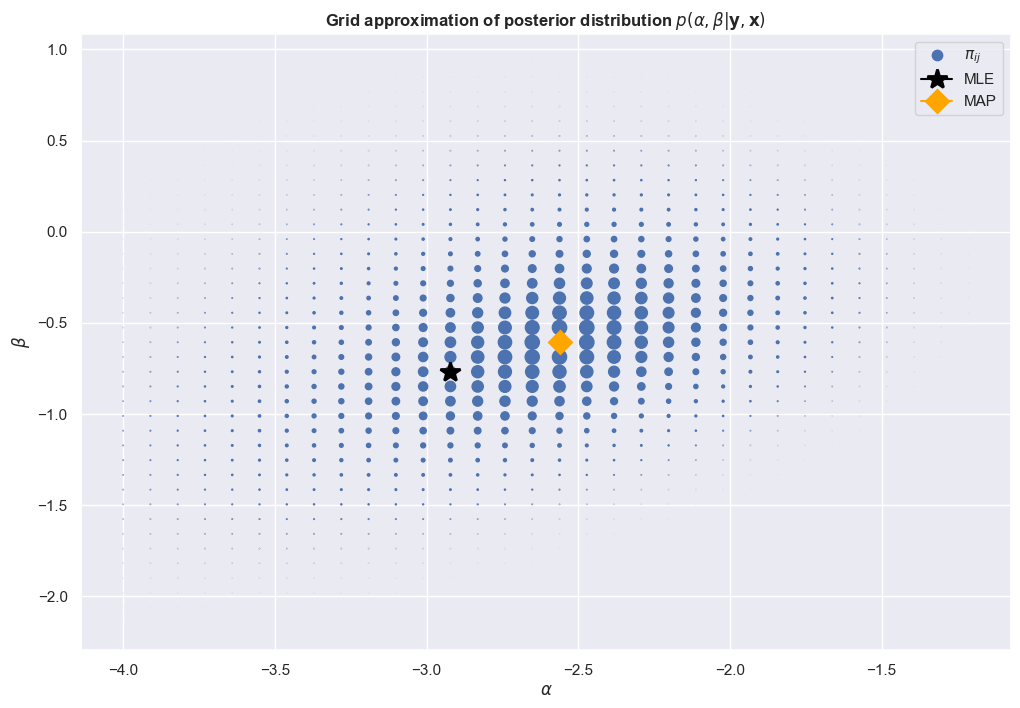

In [20]:
class GridApproximation2D(Grid2D):
    """
    Approximates the posterior p(α, β | y, x) using a 2D grid.
    Inherits from Grid2D, which provides the grid structure.
    """

    def __init__(self, alphas, betas, log_joint, threshold=1e-8, name="GridApproximation2D"):
        """
        Args:
            alphas: 1D array of α grid points, shape [num_alpha]
            betas: 1D array of β grid points, shape [num_beta]
            log_joint: function (α, β) -> log p(y, α, β | x), vectorized over α, β
            threshold: float, probability threshold for visualization
            name: str, name for the approximation
        """
        # Initialize the parent Grid2D class
        Grid2D.__init__(self, alphas, betas, log_joint, name)
        self.threshold = threshold
        # Prepare the grid approximation (normalize, flatten, etc.)
        self.prep_approximation()
        # Compute marginal distributions for α and β
        self.compute_marginals()
        # Sanity check for probability grid
        self.sanity_check()

    def prep_approximation(self):
        """
        Prepares the grid approximation for the posterior distribution.

        Steps:
        1. Shift the log joint grid so that the maximum value is 0 (for numerical stability).
        2. Exponentiate the shifted log joint values to obtain unnormalized joint probabilities.
        3. Compute the normalization constant (Z) by summing the unnormalized probabilities.
        4. Normalize the grid so that the probabilities sum to 1.
        5. Flatten the grid arrays for later convenience (e.g., expectation computation, sampling).

        Shapes:
            self.log_joint_grid: [num_alpha, num_beta]
            self.tilde_probabilities_grid: [num_alpha, num_beta]
            self.probabilities_grid: [num_alpha, num_beta]
            self.alphas_flat: [num_alpha * num_beta]
            self.betas_flat: [num_alpha * num_beta]
            self.probabilities_flat: [num_alpha * num_beta]
        """
        # 1) log_joint_grid is the log of p(y, α, β | x) at each grid point
        self.log_joint_grid = self.values  # [num_alpha, num_beta]

        # 2) Numerical stability: subtract max log-prob before exponentiating
        # log_joint_grid ← log_joint_grid - max(log_joint_grid)
        self.log_joint_grid = self.log_joint_grid - jnp.max(self.log_joint_grid)

        # 3) Exponentiate to get unnormalized probabilities:
        # τ_ij = exp(log p(y, α_i, β_j | x))
        self.tilde_probabilities_grid = jnp.exp(self.log_joint_grid)  # [num_alpha, num_beta]

        # 4) Compute normalization constant:
        # Z = sum_{i,j} τ_ij
        self.Z = jnp.sum(self.tilde_probabilities_grid)

        # 5) Normalize:
        # π_ij = τ_ij / Z
        self.probabilities_grid = self.tilde_probabilities_grid / self.Z  # [num_alpha, num_beta]

        # 6) Flatten for convenience
        # α_grid, β_grid: [num_alpha, num_beta] → [num_alpha * num_beta]
        self.alphas_flat = self.alpha_grid.flatten()   # [num_alpha * num_beta]
        self.betas_flat = self.beta_grid.flatten()     # [num_alpha * num_beta]
        self.num_outcomes = len(self.alphas_flat)      # Scalar: num_alpha * num_beta
        self.probabilities_flat = self.probabilities_grid.flatten()  # [num_alpha * num_beta]

    def compute_marginals(self):
        """
        Computes and stores the marginal distributions over α and β.

        Equations:
            π_α[i] = sum_j π_ij   (sum over β for each α)
            π_β[j] = sum_i π_ij   (sum over α for each β)

        Output shapes:
            self.pi_alpha: [num_alpha]
            self.pi_beta: [num_beta]
        """
        # Marginal for α: sum over β axis (axis=1)
        self.pi_alpha = jnp.sum(self.probabilities_grid, axis=1)  # [num_alpha]
        # Marginal for β: sum over α axis (axis=0)
        self.pi_beta = jnp.sum(self.probabilities_grid, axis=0)   # [num_beta]

    def compute_expectation(self, f):
        """
        Computes the expectation E[f(α, β)] under the grid approximation.

        Args:
            f: function (alphas_flat, betas_flat) → array of shape [num_alpha * num_beta] or broadcastable

        Returns:
            Scalar or array: E[f(α, β)] = sum_{i,j} f(α_i, β_j) * π_ij

        Input shapes:
            alphas_flat: [num_alpha * num_beta]
            betas_flat: [num_alpha * num_beta]
            probabilities_flat: [num_alpha * num_beta]
        """
        return jnp.sum(f(self.alphas_flat, self.betas_flat) * self.probabilities_flat, axis=0)

    def sample(self, key, num_samples=1):
        """
        Generates samples from the grid approximation of the posterior.

        Args:
            key: JAX PRNG key
            num_samples: int, number of samples

        Returns:
            (sampled_alphas, sampled_betas): tuple of arrays, each shape [num_samples, 1]

        Sampling equation:
            idx ~ Categorical(probabilities_flat)
            α_sample = alphas_flat[idx]
            β_sample = betas_flat[idx]
        """
        idx = random.choice(key, jnp.arange(self.num_outcomes), p=self.probabilities_flat, shape=(num_samples, 1))
        return self.alphas_flat[idx], self.betas_flat[idx]

    def visualize(self, ax, scaling=8000, title='Grid approximation'):
        """
        Visualizes the grid approximation on a scatter plot.

        Args:
            ax: matplotlib axis object
            scaling: float, marker size scaling factor
            title: str, plot title

        Only points with π_ij > threshold are plotted.
        """
        idx = self.probabilities_flat > self.threshold
        ax.scatter(self.alphas_flat[idx], self.betas_flat[idx], scaling * self.probabilities_flat[idx], label='$\\pi_{ij}$')
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(title, fontweight='bold')

    def sanity_check(self):
        """
        Performs basic assertions to ensure that the probability grid:
          - Has the correct shape.
          - Contains no negative values.
          - Sums to 1.

        Checks:
            probabilities_grid.shape == [num_alpha, num_beta]
            all(probabilities_grid >= 0)
            sum(probabilities_grid) ≈ 1
        """
        assert self.probabilities_grid.shape == self.grid_size, \
            "Probability grid does not have shape [num_alphas, num_betas] (self.grid_size)."
        assert jnp.all(self.probabilities_grid >= 0), \
            "Not all values in probability grid are non-negative."
        assert jnp.allclose(self.probabilities_grid.sum(), 1), \
            "Values in probability grid do not sum to one."


# --- Example usage below ---

# Define grid resolution for α and β.
num_alpha, num_beta = 90, 100
alphas = jnp.linspace(-4, 4, num_alpha)   # [num_alpha]
betas = jnp.linspace(-4, 4, num_beta)     # [num_beta]

# Instantiate the logistic regression model with the given data (x, y, N) and prior variances.
# model.log_joint: function (α, β) → log p(y, α, β | x)
model = LogisticRegression(x, y, N, sigma2_alpha=1.0, sigma2_beta=1.0)

# Construct grid approximation of the posterior using the model's log_joint function.
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')

# Plot the grid approximation
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
post_approx.visualize(ax, title='Grid approximation of posterior distribution $p(\\alpha, \\beta| \\mathbf{y}, \\mathbf{x})$')

# Overlay MLE and MAP estimates on the grid visualization.
# alpha_MLE, beta_MLE: scalars, MLE estimates
# alpha_MAP, beta_MAP: scalars, MAP estimates
ax.plot(alpha_MLE, beta_MLE, 'black', label='MLE', markersize=15, marker='*', markeredgewidth=2)
ax.plot(alpha_MAP, beta_MAP, 'orange', label='MAP', markersize=11, marker='D', markeredgewidth=2)
ax.legend()

If the previous task was implemented correctly, the code about should produce a visualization of the grid approximation. The blue dots show the position of all the grid points, and the radius of the blue dots is controlled by the size of the corresponding weight $\pi_{ij}$. For easier interpretation, we do not plot points where $\pi_{ij}$ is smaller than $10^{-8}$. 


Our first order of business after having obtained the posterior distribution is to produce estimates of the parameters $\alpha$ and $\beta$ as well to quantify the uncertainty, i.e. we will estimate the posterior mean, posterior standard deviation and 95% credibility interval for both $\alpha$ and $\beta$. For this purpose, it is more convenient to work with the marginal posterior distributions of $\alpha$ and $\beta$, which can be readily obtained from the joint posterior approximation $q(\alpha, \beta)$ using the **sum rule**:

$\begin{align*}
q(\alpha_i) &= \sum_{j} q(\alpha_i, \beta_j) = \sum_{j} \pi_{ij} = \pi^{\alpha}_i\\
q(\beta_j) &= \sum_{i} q(\alpha_i, \beta_j) = \sum_{i} \pi_{ij} = \pi^{\beta}_j,
\end{align*}$

i.e. $\pi^{\alpha} = q(\alpha_i)$ is the (approximate) marginal posterior probability of $p(\alpha = \alpha_i|\mathbf{y}, \mathbf{x})$.

**Task 4.2**: Go back up the class $\texttt{GridApproximation2D}$ and implemented the $\texttt{compute marginals}$-function. Use it to compute and plot the probability mass functions for the approximate posterior marginal distributions $q(\alpha)$ and $q(\beta)$ as a function of $\alpha$ and $\beta$, respectively.

**Solution**


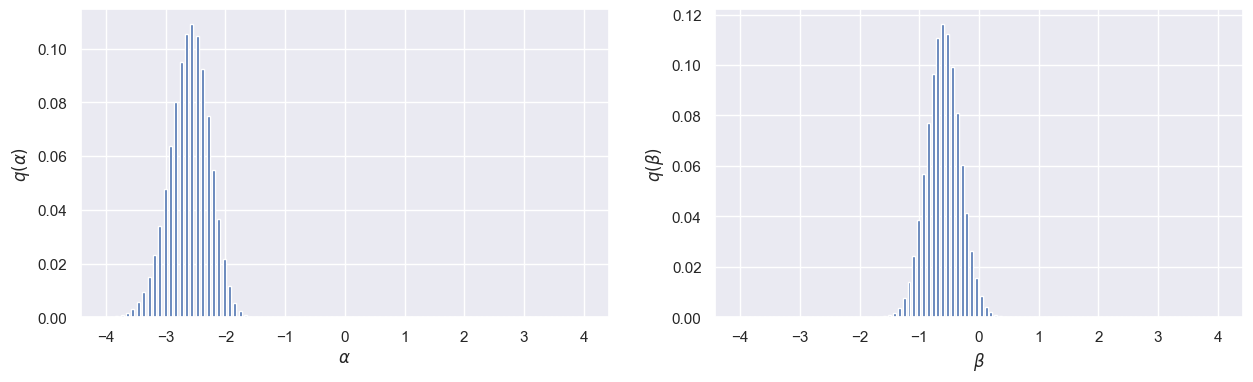

In [22]:
# Plot the marginal posterior distributions for alpha and beta

# Create a figure with 1 row and 2 columns of subplots, set the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the marginal posterior for alpha (q(alpha)) as a bar plot
# post_approx.alphas: grid values for alpha
# post_approx.pi_alpha: marginal probabilities for alpha
ax[0].bar(post_approx.alphas, post_approx.pi_alpha, width=0.05)
ax[0].set(xlabel='$\\alpha$', ylabel='$q(\\alpha)$')  # Set axis labels

# Plot the marginal posterior for beta (q(beta)) as a bar plot
# post_approx.betas: grid values for beta
# post_approx.pi_beta: marginal probabilities for beta
ax[1].bar(post_approx.betas, post_approx.pi_beta, width=0.05)
ax[1].set(xlabel='$\\beta$', ylabel='$q(\\beta)$')  # Set axis labels
plt.show();

**End of solution**


**Task 4.3**: Compute the posterior mean and standard deviation for $\alpha$ and $\beta$ using the grid approximation by completing the implementation of `DiscreteDistribution1D`-class below. Use the figures from the previous task to verify that your results are (approximately) correct.

*Hints*:
- The mean of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{E}\left[X\right] = \sum_{i} x_i P(X = x_i)$, where the sum is over all the possible outcomes of $X$.
- The variance of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{V}\left[X\right] = \sum_{i} \left(x_i - \mathbb{E}\left[X\right]\right)^2 P(X = x_i)$, where the sum is over all the possible outcomes of $X$.


In [23]:
class DiscreteDistribution1D(object):
    """
    Represents a discrete random variable X in terms of its outcomes and probabilities.
    Provides methods for summary statistics and quantiles.
    """

    def __init__(self, outcomes, probabilities, name='DiscreteDistribution'):
        """
        Initialize the discrete distribution.

        Parameters:
            outcomes: 1D array of possible values of X. Shape: (n,)
            probabilities: 1D array of probabilities for each outcome. Shape: (n,)
            name: Optional string name for the distribution.

        Output:
            self.outcomes: (n,)
            self.probabilities: (n,)
        """
        self.outcomes = outcomes
        self.probabilities = probabilities
        assert self.outcomes.shape == self.probabilities.shape
        self.name = name

    def CDF(self, x):
        """
        Compute the cumulative distribution function P[X <= x].

        Equation:
            CDF(x) = sum_{i: outcomes[i] <= x} probabilities[i]

        Input:
            x: scalar

        Output:
            Scalar, sum of probabilities for outcomes <= x
        """
        idx = self.outcomes <= x
        return jnp.sum(self.probabilities[idx]) 
    
    def quantile(self, p):
        """
        Compute the quantile function Q(p) = inf {x | p < CDF(x)}.

        Equation:
            Q(p) = min { x_i | CDF(x_i) >= p }

        Input:
            p: scalar in [0, 1]

        Output:
            Scalar, smallest outcome x such that CDF(x) >= p
        """
        cdf_values = jnp.cumsum(self.probabilities) 
        idx = jnp.where(jnp.logical_or(p < cdf_values, jnp.isclose(p, cdf_values)))[0]
        return jnp.min(self.outcomes[idx])
    
    @property
    def mean(self):
        """
        Compute the mean (expected value) of the discrete distribution.

        Equation:
            E[X] = sum_i outcomes[i] * probabilities[i]

        Output:
            Scalar mean
        """
        return jnp.sum(self.outcomes * self.probabilities)  
    
    @property
    def variance(self):
        """
        Compute the variance of the discrete distribution.

        Equation:
            Var[X] = sum_i (outcomes[i] - mean)^2 * probabilities[i]

        Output:
            Scalar variance
        """
        return jnp.sum((self.outcomes - self.mean)**2 * self.probabilities)  
    
    def central_interval(self, interval_size=95):
        """
        Compute the central credibility interval of the distribution.

        Equation:
            For interval_size=95, returns [Q(0.025), Q(0.975)]

        Input:
            interval_size: float, e.g. 95 for 95% interval

        Output:
            jnp.array([lower, upper]), shape (2,)
        """
        c = 1. - interval_size / 100.
        lower = self.quantile(c / 2)
        upper = self.quantile(1 - c / 2)
        return jnp.array([lower, upper])  
    
    def print_summary(self):
        """
        Print summary statistics: mean, std, and 95% credibility interval.

        Output:
            Prints to stdout.
        """
        print(f'Summary for {self.name}')
        print(f'\tMean:\t\t\t\t{self.mean:3.2f}')
        print(f'\tStd. dev.:\t\t\t{jnp.sqrt(self.variance):3.2f}')
        print(f'\t95%-credibility interval:\t[{self.central_interval()[0]:3.2f}, {self.central_interval()[1]:3.2f}]\n')


# Example use and sanity checks using a classic six-sided die
# outcomes: [1, 2, 3, 4, 5, 6], probs: [1/6, ..., 1/6]
outcomes, probs = jnp.arange(1, 6 + 1), jnp.ones(6) / 6
sixsided_die = DiscreteDistribution1D(outcomes, probs)
assert jnp.allclose(sixsided_die.mean, 3.5), f"The mean of a sixsided die should be 3.5, but the value was {sixsided_die.mean:3.2f}. Check your implementation."
assert jnp.allclose(sixsided_die.variance, 35 / 12), f"The variance of a sixsided die should be approximately 2.92, but the value was {sixsided_die.variance:3.2f}. Check your implementation."
assert jnp.allclose(sixsided_die.central_interval(95), jnp.array([1, 6])), f"The (approximate) 95% central interval of a sixsided die should be (1,6), but the value was {sixsided_die.central_interval(95)}. Check your implementation."

# Summarize posterior marginals for alpha and beta
# Input: post_approx.alphas (n,), post_approx.pi_alpha (n,)
post_alpha_marginal = DiscreteDistribution1D(post_approx.alphas, post_approx.pi_alpha, "posterior distribution of alpha")
post_beta_marginal = DiscreteDistribution1D(post_approx.betas, post_approx.pi_beta, "posterior distribution of beta")

post_alpha_marginal.print_summary()
post_beta_marginal.print_summary()


Summary for posterior distribution of alpha
	Mean:				-2.61
	Std. dev.:			0.33
	95%-credibility interval:	[-3.28, -2.02]

Summary for posterior distribution of beta
	Mean:				-0.60
	Std. dev.:			0.28
	95%-credibility interval:	[-1.17, -0.04]



Compare the summary statistics to the plots above. Verify that your results are consistent before moving on.




**Task 4.4**: Compute the prior and posterior probability that $\beta < 0$

**Solution**

In [29]:
# Compute the prior and posterior probability that beta < 0

# Construct a grid approximation for the prior over (alpha, beta)
# Input: alphas (num_alpha,), betas (num_beta,), model.log_prior (function)
# Output: prior_approx (GridApproximation2D object)
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# Compute the marginal distribution for beta under the prior
# Input: prior_approx.betas (num_beta,), prior_approx.pi_beta (num_beta,)
# Output: prior_beta_marginal (DiscreteDistribution1D object)
prior_beta_marginal = DiscreteDistribution1D(prior_approx.betas, prior_approx.pi_beta, "prior distribution of beta")

# Compute and print the probability that beta < 0 under the prior
# Input: 0 (scalar), Output: scalar probability
print(f'p(beta < 0) = {prior_beta_marginal.CDF(0):3.2f}')

# Compute and print the probability that beta < 0 under the posterior
# Input: 0 (scalar), Output: scalar probability
print(f'p(beta < 0|y) = {post_beta_marginal.CDF(0):3.2f}')

p(beta < 0) = 0.50
p(beta < 0|y) = 0.98


**End of solution**


# Part 5:  Propagating uncertainty from parameters to predictions

Using the grid approximation, we got a handle on the posterior distribution of $\alpha$ and $\beta$ given the observed data, i.e. $p(\alpha, \beta|\mathbf{x}, \mathbf{y})$. We will now turn our attention to making predictions. For example, we want to predict the following quantities for a given temperature $t^* \in \mathbb{R}$:

- The probability of failure for each o-ring
- The probability of at least one o-ring failing
- The expected number of failing o-rings
- A 95\%-credibility interval for then number of failed o-rings

**Assuming we know** the value of $\alpha$ and $\beta$, all quantities above are easily computed from the predictive likelihood

$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N^*, \alpha, \beta)
\end{align}
$

However, in practice we do not now the value of $\alpha$ and $\beta$, and therefore, we need to estimate them. The simplest approach for making predictions is to use a **plugin approximation** like we did in part 3. That is, we simply plug in one of our point estimates for $\alpha$ and $\beta$ into the equation above, e.g. the MLE or MAP estimator. This is usually fast and easy to do, but the significant drawback is that it tends to produce **overconfident** predictions because it ignores the uncertainty for $\theta^*$. Instead, we can propagate the uncertainty from the posterior distribution $q(\alpha, \beta)$ to the predictive distribution using **marginalization** via the sum:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int \int p(y^*|x^*, \alpha, \beta) p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \text{d}\alpha \text{d}\beta = \mathbb{E}_{p(\alpha, \beta|\mathbf{y}, \mathbf{x})}\left[p(y^*|x^*, \alpha, \beta)\right] \approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right].
\end{align}$

That is, when we make predictions, we average over the posterior distribution. **Instead of picking a single set of parameters, we consider all possible values for $\alpha$ and $\beta$ and weigh them according to their posterior probability**. This may be abstract, but the grid approximation can help understand this more intuitively:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \mathbb{E}_{p(\alpha, \beta|\mathbf{y})}\left[p(y^*|x^*, \alpha, \beta)\right]\approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right] = \sum_{ij} p(y^*|x^*, \alpha_i, \beta_j) \pi_{ij},
\end{align}
$

where we literally evaluate $p(y^*|x^*, \alpha, \beta)$ for each possible set of parameters $(\alpha_i, \beta_j)$ and weigh them by the posterior probability $\pi_{ij} = q(\alpha_i, \beta_j)$. We refer to the distribution $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ as the **posterior predictive distribution**. Recall, we can also cast the plugin approximations as approximation over the posterior predictive distribution, where the posterior is approximated by a posterior distribution that as all the mass on the single point $(\hat{\alpha}_{MLE}, \hat{\beta}_{\text{MLE}})$.


The code below uses the plugin approximation for the MLE/MAP estimator to compute and plot the posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ for $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$. The code also reports the mean and a 95\% interval for each methods for each temperatures (assuming the tasks above have been solved). 

**Task 5.1**: Compute and plot and the full posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ with $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$ for $t = 25^{\circ}C$ and $t = 0^{\circ}C$. 



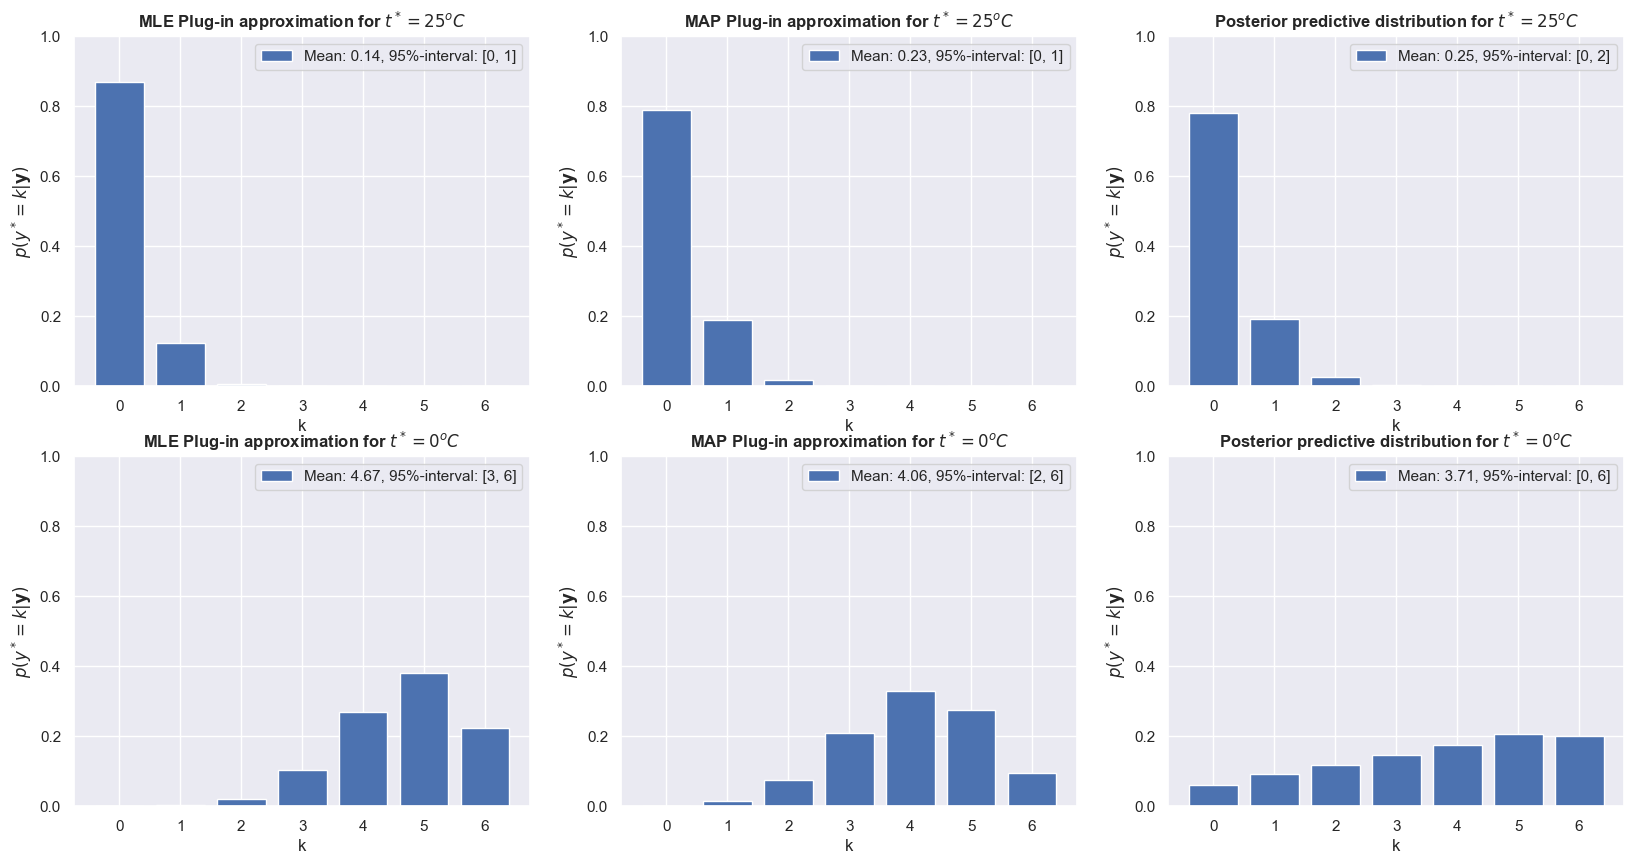

In [ ]:
# Define target temperatures for which predictions will be made.
# In this example, we want to compute predictions at t = 25°C and t = 0°C.
temp_stars = [25, 0]

# Define the outcome space for y^*, which represents the possible number of failures.
# Here we assume the number of failures can be 0, 1, 2, ..., 6.
ks = jnp.arange(0, 6+1)

# Define the predictive likelihood function p(y^*=k | x^*, alpha, beta).
# It uses the binomial probability mass function (pmf).
# The function model.theta computes p (the probability of failure) for the standardized input x_star.
# 'binom_dist.pmf' calculates the probability of k failures out of 6 trials.
pred_lik = lambda k, x_star, alpha, beta: binom_dist.pmf(k=k, n=6, p=model.theta(x_star, alpha, beta)) # p(y^*=k | x^*, alpha, beta) is the probability of k failures given x_star, alpha, and beta.

# Create a figure with a grid of subplots.
# There will be 2 rows (one for each temperature) and 3 columns (one for each prediction method).
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Define a lambda function that formats a string with the distribution's mean and its 95% credibility interval.
# This label will be used in the legend of the plots.
mean_and_interval_label = lambda dist: f'Mean: {dist.mean:3.2f}, 95%-interval: [{dist.central_interval()[0]:d}, {dist.central_interval()[1]:d}]'

# Loop over each target temperature along with an index.
for n, t_star in enumerate(temp_stars):

    # Standardize the temperature to obtain x^*. The function 'standardize' is assumed to
    # use the provided tmean and tstd to convert the temperature into the model's input scale.
    x_star = standardize(t_star)

    # Compute the predictive likelihood probabilities using the plug-in MLE estimator.
    # This evaluates the predictive likelihood at all outcome points (ks) for x_star using alpha_MLE and beta_MLE.
    # Compute the predictive likelihood probabilities using the plug-in MLE estimator.
    # Equation:
    # pred_lik_probs_MLE[k] = p(y^* = k | x^*, alpha_MLE, beta_MLE)
    #                       = BinomialPMF(k; n=6, p=sigma(alpha_MLE + beta_MLE * x^*))
    pred_lik_probs_MLE = pred_lik(ks, x_star, alpha_MLE, beta_MLE)
    
    # Compute the predictive likelihood probabilities using the plug-in MAP estimator.
    # This evaluates the predictive likelihood at all outcome points (ks) for x_star using alpha_MAP and beta_MAP.
    # Compute the predictive likelihood probabilities using the plug-in MAP estimator.
    # Equation:
    # pred_lik_probs_MAP[k] = p(y^* = k | x^*, alpha_MAP, beta_MAP)
    #                       = BinomialPMF(k; n=6, p=sigma(alpha_MAP + beta_MAP * x^*))
    pred_lik_probs_MAP = pred_lik(ks, x_star, alpha_MAP, beta_MAP)
    
    # Compute the posterior predictive distribution by averaging over all parameter values,
    # weighted by their posterior probability. The resulting probabilities should be an array of shape [7]
    # so that each element corresponds to the probability of k failures. 
    # Compute the full posterior predictive distribution by marginalizing over the posterior grid:
    # For each k, sum over all (alpha, beta) grid points, weighting by the posterior probability.
    # Equation:
    # pred_lik_bayes_probs[k] = sum_{i,j} p(y^*=k | x^*, alpha_i, beta_j) * pi_{ij}
    # where pi_{ij} = post_approx.probabilities_grid[i, j]
    pred_lik_bayes_probs = jnp.sum(
        post_approx.probabilities_grid[:, :, None] * pred_lik(
            ks, x_star, post_approx.alpha_grid[:, :, None], post_approx.beta_grid[:, :, None]
        ),
        axis=(0, 1)
    )


    # Prepare discrete distributions for plotting.
    # Create a DiscreteDistribution1D instance for the plug-in MLE predictions.
    pred_dist_MLE = DiscreteDistribution1D(ks, pred_lik_probs_MLE, name='MLE Plug-in approximation')
    # Create a DiscreteDistribution1D instance for the plug-in MAP predictions.
    pred_dist_MAP = DiscreteDistribution1D(ks, pred_lik_probs_MAP, name='MAP Plug-in approximation')
    # Create a DiscreteDistribution1D instance for the full Bayesian (posterior predictive) predictions.
    pred_dist_bayes = DiscreteDistribution1D(ks, pred_lik_bayes_probs, name="Posterior predictive distribution")

    # For each prediction method, create a bar plot on the corresponding subplot.
    # The plots display the probabilities for each outcome in ks.
    for i, dist in enumerate([pred_dist_MLE, pred_dist_MAP, pred_dist_bayes]):
        # Create a bar plot: x-axis is the outcome (k) and y-axis is the probability.
        # The label includes the mean and 95% credibility interval for the distribution.
        ax[n, i].bar(ks, dist.probabilities, label=mean_and_interval_label(dist))
        # Set the axis labels and limits for visual consistency.
        ax[n, i].set(xlabel='k', ylabel='$p(y^* = k|\\mathbf{y})$', ylim=(0, 1))
        # Set the title indicating which prediction method is used and for which temperature.
        ax[n, i].set_title(f'{dist.name} for $t^* = {t_star}^oC$', fontweight='bold')
        # Add legend to the plot to display distribution summary.
        ax[n, i].legend()


**Task 5.2**: Comment on the differences between the results obtained using plugin approximations, i.e. the MLE/MAP estimators, and the posterior predictive distributions. How does the three approximations compare? In regions with data? In regions without data?


## Comparing Predictive Distributions: MLE, MAP, and Full Bayesian

### **MLE Plug-in**

- You fix $\theta^* = \sigma(\hat{\alpha}_{\text{MLE}} + \hat{\beta}_{\text{MLE}} \cdot x^*)$
- Then you draw $y^* \sim \text{Bin}(N^*, \theta^*)$
- All of your predictive mass sits on that single point estimate of $\theta^*$.
- The resulting PMF is **too tight**:
  - Zero probability for any outcome that $\theta^*$ says is impossible.
  - Very narrow credible intervals.

---

### **MAP Plug-in**

- Same story, but now $\theta^* = \sigma(\hat{\alpha}_{\text{MAP}} + \hat{\beta}_{\text{MAP}} \cdot x^*)$
- If your prior is non-flat, it shifts $\hat{\theta}$ and thus the mean prediction.
- Still **ignores** any remaining uncertainty around $\alpha$ and $\beta$.
- PMF is nearly as narrow as MLE, just **re-centered**.

---

### **Full Posterior Predictive**

- You average the Binomial PMF over all pairs $(\alpha_i, \beta_j)$ on your grid:
  - Weighted by their posterior probabilities $\pi_{ij}$.
- This mixture of Binomials:
  - **Stays wide** wherever parameter uncertainty is high.
  - **Collapses** toward the plug-in where posterior on $(\alpha, \beta)$ is tight.

#### Behavior:
- **Data-rich regions** → tight posterior → predictive collapses to plug-in.
- **Data-poor/extrapolated regions** → broad posterior → wider, fatter-tailed predictive.

---

## 🔍 In the Plots Above

### **Top row** ($t^* = 25^\circ C$)
- Temperature lies **within training range**.
- MLE, MAP, and full-Bayes means are all similar:
  - Approx. 0.14 (MLE), 0.23 (MAP), 0.25 (Bayes).
- MLE/MAP bars are sharp:
  - 95% interval spans just 1–2 values of $k$.
- Full Bayes:
  - Slightly more mass on adjacent $k$ values.
  - Wider 95% band (captures residual $\alpha/\beta$ uncertainty).

### **Bottom row** ($t^* = 0^\circ C$)
- **Extreme extrapolation** (no training data at this temp).
- MLE:
  - Predicts $y^* \approx 5$ failures with **tiny spread** → **overconfident**.
- MAP:
  - Similar to MLE but **re-centered** slightly by prior (pulls slope toward zero).
- Bayesian Predictive:
  - Much flatter distribution:
    - Non-negligible mass from 0 to 6 failures.
    - Mean ≈ 3.7
    - 95% interval = [0, 6]

---

## ✅ Bottom Line

- **Plug-in (MLE/MAP)**:
  - Fast and easy.
  - **Systematically underestimates uncertainty**, especially **outside** the training data range.

- **Full Posterior Predictive**:
  - True average over all plausible parameter values.
  - **Automatically adapts**: uncertainty **increases** where data is sparse, and **shrinks** where data is rich.


_________



In the very last of the exercise, we will visualize the posterior for $f(x)$ and $\theta(x)$ to build over intuition. We will start by drawing a set of random samples of $(\alpha, \beta)$ from the posterior approximation and then compute and visualize $f(x)$ and $\theta(x)$ for each sample. We will repeat this process for the prior distribution $p(\alpha, \beta)$.

**Task 5.3**: The code below generates $\texttt{num samples}$ of $\alpha, \beta$ from both the prior and posterior and plots them. Compute $f(x_{\text{pred}})$ and $\theta(x_{\text{pred}})$ for each of these samples and store them in the variables $\texttt{f samples}$ and $\texttt{theta samples}$ pre-defined below. 

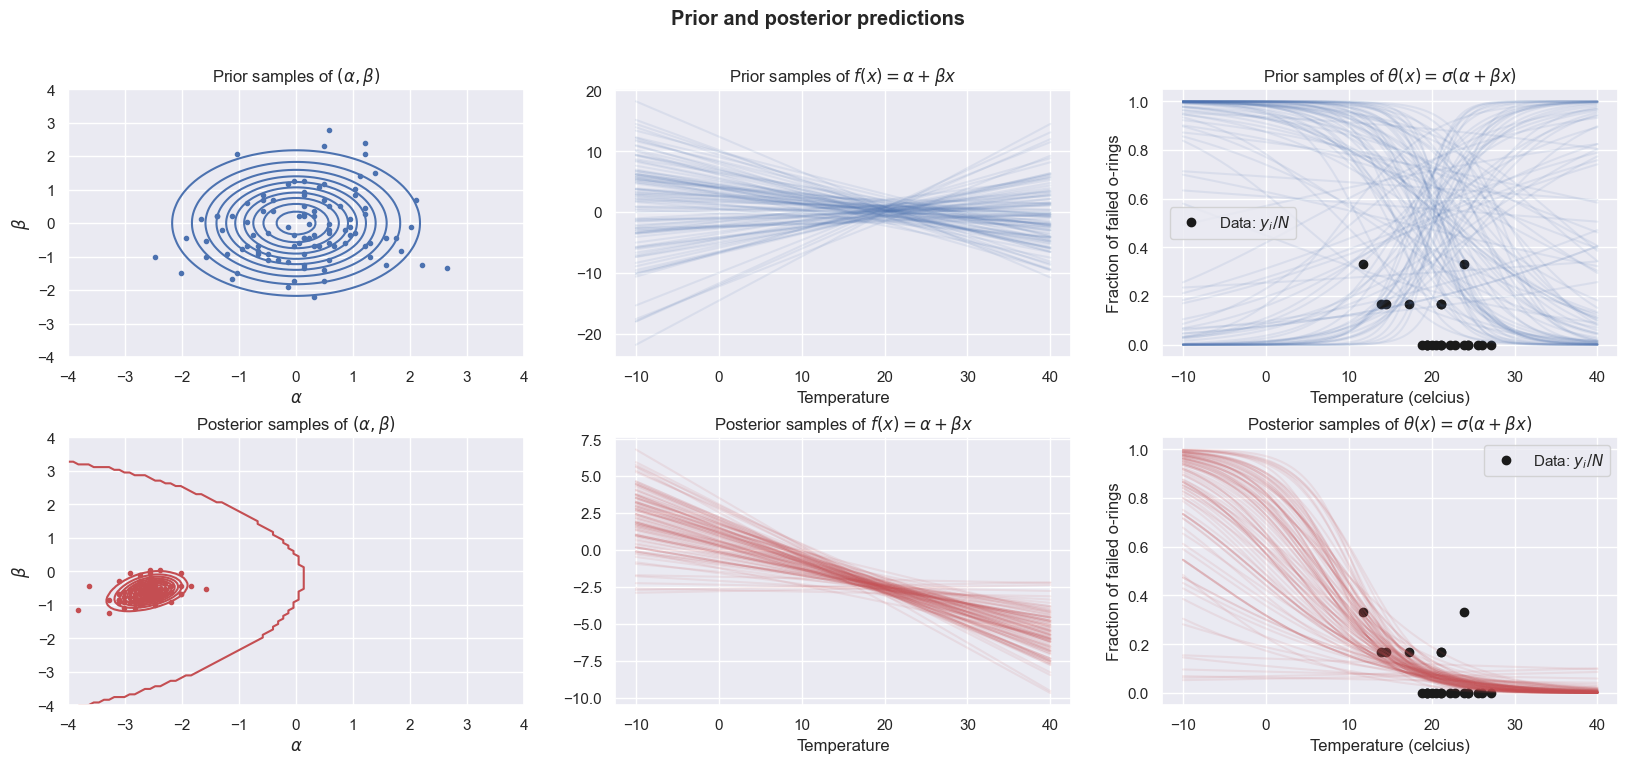

In [35]:
# INPUT:
#   temp_pred: 1D array of temperatures (in Celsius) for prediction, shape [500]
#   tmean, tstd: scalars, mean and std for standardization
#   x_pred: 1D array, standardized temperatures, shape [500]
#   N_pred: int, number of o-ring trials per prediction
#   num_samples: int, number of (alpha, beta) samples to draw for visualization
#   alphas, betas: 1D arrays, grid points for alpha and beta
#   x, y, N: observed data (standardized), outcomes, and number of trials
#   model: LogisticRegression object, provides f(x, alpha, beta) and theta(x, alpha, beta)
#   post_approx, prior_approx: GridApproximation2D objects for posterior and prior
#   seed: int, random seed for reproducibility
#   random: JAX random module
#   plot_data: function to plot observed data
#   colors: list of color codes for plotting

# OUTPUT:
#   Visualization of:
#     - (alpha, beta) samples from prior and posterior on contour plots
#     - f(x_pred) and theta(x_pred) curves for each sample
#   Variables:
#     - f_samples: (num_samples, len(temp_pred)), sampled linear predictors for each x_pred
#     - theta_samples: (num_samples, len(temp_pred)), sampled probabilities for each x_pred

# Data for predictions:
# Generate a set of temperature points (in Celsius) for which we want to compute predictions.
temp_pred = jnp.linspace(-10, 40, 500)
# Standardize the temperatures using the model's standardization (tmean and tstd are already defined)
x_pred = standardize(temp_pred)
# Total number of o-ring trials for each temperature prediction
N_pred = 6

# Number of samples for visualization from the prior and posterior distributions.
num_samples = 100

# Set up a grid for the alpha and beta parameters.
# num_alpha and num_beta determine the resolution of the grid.
num_alpha, num_beta = 90, 100
# Create a linearly spaced grid for alpha parameter values
alphas = jnp.linspace(-4, 4, num_alpha)
# Create a linearly spaced grid for beta parameter values
betas = jnp.linspace(-4, 4, num_beta)

# Set up the logistic regression model using the observed data (x, y) and the number of trials N.
# sigma2_alpha and sigma2_beta are the prior variances for alpha and beta.
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)

# Use a grid approximation to obtain the (approximate) posterior distribution of (alpha, beta)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
# Similarly, obtain the grid approximation for the prior distribution
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# Specify a seed for reproducibility and create a random key for sampling.
seed = 123
key = random.PRNGKey(seed)

# Create a figure with 2 rows and 3 columns of subplots.
# Each row corresponds to a distribution (first row for prior, second row for posterior)
# The columns: 0 - grid contour and sample scatter, 1 - f(x) samples, 2 - theta(x) samples.
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

# Loop through the distributions (prior and posterior) for visualization.
for idx_plot, dist in enumerate([prior_approx, post_approx]):
    # Split the random key to get a new subkey for sampling without altering the original key.
    key, subkey = random.split(key)

    # Plot the observed data and contours of the current (prior or posterior) distribution.
    # The third subplot in the current row (ax[idx_plot, 2]) will show the data.
    plot_data(ax[idx_plot, 2], counts=False)
    # Plot probability contours (after applying exponential to convert from log probabilities)
    # 'color' is picked from the colors list using the current index.
    dist.plot_contours(ax[idx_plot, 0], f=jnp.exp, color=colors[idx_plot])

    # --- Sampling from the grid approximation ---
    # Equation: (alpha_samples, beta_samples) ~ dist.sample(subkey, num_samples)
    alpha_samples, beta_samples = dist.sample(subkey, num_samples)

    # --- Compute f(x_pred) and theta(x_pred) for each sample ---
    # Equation for linear predictor:
    #   f(x) = alpha + beta * x
    # Equation for probability:
    #   theta(x) = sigmoid(f(x)) = 1 / (1 + exp(-f(x)))
    # Shapes: (num_samples, len(temp_pred))
    f_samples = model.f(x_pred, alpha_samples, beta_samples)
    theta_samples = model.theta(x_pred, alpha_samples, beta_samples)

    # Overlap the (alpha, beta) scatter plot on the contour plot in the first column.
    ax[idx_plot, 0].plot(alpha_samples, beta_samples, '.', color=colors[idx_plot])

    # Plot each sample's f(x) on the second subplot.
    # Transpose the samples so that each curve is drawn along temp_pred.
    ax[idx_plot, 1].plot(temp_pred, f_samples.T, '', color=colors[idx_plot], alpha=0.1)
    # Plot each sample's theta(x) on the third subplot.
    ax[idx_plot, 2].plot(temp_pred, theta_samples.T, '', color=colors[idx_plot], alpha=0.1)
    # Add a legend for the theta(x) plot.
    ax[idx_plot, 2].legend()

    # Set titles and labels for clarity.
    ax[idx_plot, 0].set(title=f'{dist.name} samples of $(\\alpha, \\beta)$')
    ax[idx_plot, 1].set(title=f'{dist.name} samples of $f(x) = \\alpha + \\beta x$', xlabel='Temperature')
    ax[idx_plot, 2].set(title=f'{dist.name} samples of $\\theta(x) = \\sigma(\\alpha + \\beta x)$')

# Set a global title for the entire figure.
fig.suptitle('Prior and posterior predictions', fontweight='bold')
# Adjust vertical spacing between subplots for improved layout.
fig.subplots_adjust(hspace=0.3)


> **Task 5.4**: Study the code and plots above and make sure you can explain the following:
> 
> - What is plotted in each of the six panels? 
> - What is the relationship between each of the dots in the left columns and the curves in the center and right columns?
> - How the uncertainty on $f(x)$ and $\theta(x)$ is controlled by the distribution of $(\alpha, \beta)$?
> - How well does each of the prior samples match the observed data?
> - How well does each of the posterior samples match the observed data?


# Overview of the Six Panels

We have two rows (“Prior” and “Posterior”) and three columns (“$(\alpha, \beta)$ samples,” “$f(x)$ curves,” and “$\theta(x)$ curves”).

## Row 1: Prior

1. **Leftmost panel (“Prior samples of $(\alpha, \beta)$”)**
   - Blue contours: iso-density lines of the prior
   - Blue dots: i.i.d. draws $\left\{(\alpha_i, \beta_i)\right\}_{i=1}^{100} \sim \mathcal{N} \left( (0,0), \operatorname{diag}(1,1) \right)$

2. **Middle panel (“Prior samples of $f(x) = \alpha + \beta x$”)**
   - For each draw $(\alpha_i, \beta_i)$, plot the line  
     $$f_i(x) = \alpha_i + \beta_i x, \quad x \in [-10, 40].$$
   - Because $\alpha, \beta$ are very “wide,” the fan of lines spans almost every slope and intercept.

3. **Rightmost panel (“Prior samples of $\theta(x) = \sigma(\alpha + \beta x)$”)**
   - Apply the logistic sigmoid  
     $$\sigma(z) = \frac{1}{1 + e^{-z}}$$  
     to each line $f_i(x)$, giving  
     $$\theta_i(x) = \sigma(f_i(x)).$$
   - You see every possible “S-shape” you could imagine.

---

## Row 2: Posterior

1. **Leftmost panel (“Posterior samples of $(\alpha, \beta)$”)**
   - Red contours: iso-density lines of the posterior
   - Red dots: i.i.d. draws $\left\{(\alpha_j, \beta_j)\right\}_{j=1}^{100} \sim p(\alpha, \beta \mid \mathbf{x}, \mathbf{y})$
   - Notice $\beta < 0$ almost always (failure probability falls with $x$).

2. **Middle panel (“Posterior samples of $f(x) = \alpha + \beta x$”)**
   - For each posterior draw $(\alpha_j, \beta_j)$, plot  
     $$f_j(x) = \alpha_j + \beta_j x.$$
   - The ribbon of lines is now tightly bunched (much less slope/intercept variation).

3. **Rightmost panel (“Posterior samples of $\theta(x) = \sigma(\alpha + \beta x)$”)**
   - Transform each $f_j(x)$ via the sigmoid:  
     $$\theta_j(x) = \sigma(f_j(x)).$$
   - All 100 red curves pass near the black data points $\left\{(x_i, y_i/N)\right\}$.

---

# How It All Ties Together

1. **Dots → Curves**
   - Each dot in the left panel is one sample $(\alpha, \beta)$.
   - That same pair generates exactly one straight line in the middle panel and one S-curve in the right panel.

2. **Uncertainty Propagation**
   - **Prior:**  
     $\text{Var}(\alpha)$ and $\text{Var}(\beta)$ are large  
     $\Rightarrow$ wide fan of $f(x)$  
     $\Rightarrow$ wildly different $\theta(x)$.
   - **Posterior:**  
     $\text{Var}(\alpha \mid \text{data})$ and $\text{Var}(\beta \mid \text{data})$ much smaller  
     $\Rightarrow$ narrow ribbon of $f(x)$  
     $\Rightarrow$ tight bundle of $\theta(x)$.

3. **Fit to the Data**
   - Prior curves bear no relationship to the black data points (that’s “before seeing data”).
   - Posterior curves almost all go right through the data: the Bayesian update has concentrated mass on parameter values that explain those points.

4. **Behavior in Extrapolation Regions**
   - Where we have no observed $(x, y)$ (e.g., very cold or very hot), the posterior ribbon widens slightly  
     $\Rightarrow$ predictive uncertainty grows.

---

# Key Takeaways

- **Sampling** from $p(\alpha, \beta)$ and plotting forward makes it crystal-clear how parameter uncertainty turns into predictive uncertainty.
- The **prior** fan shows “everything we thought possible before seeing data.”
- The **posterior** fan shows “everything still plausible after seeing data,” tightly hugging the empirical failure rates.


______

We can also use posterior samples to the summarize the pointwise posterior mean and 95\% intervals of $f(x)$ and $\theta(x)$ :

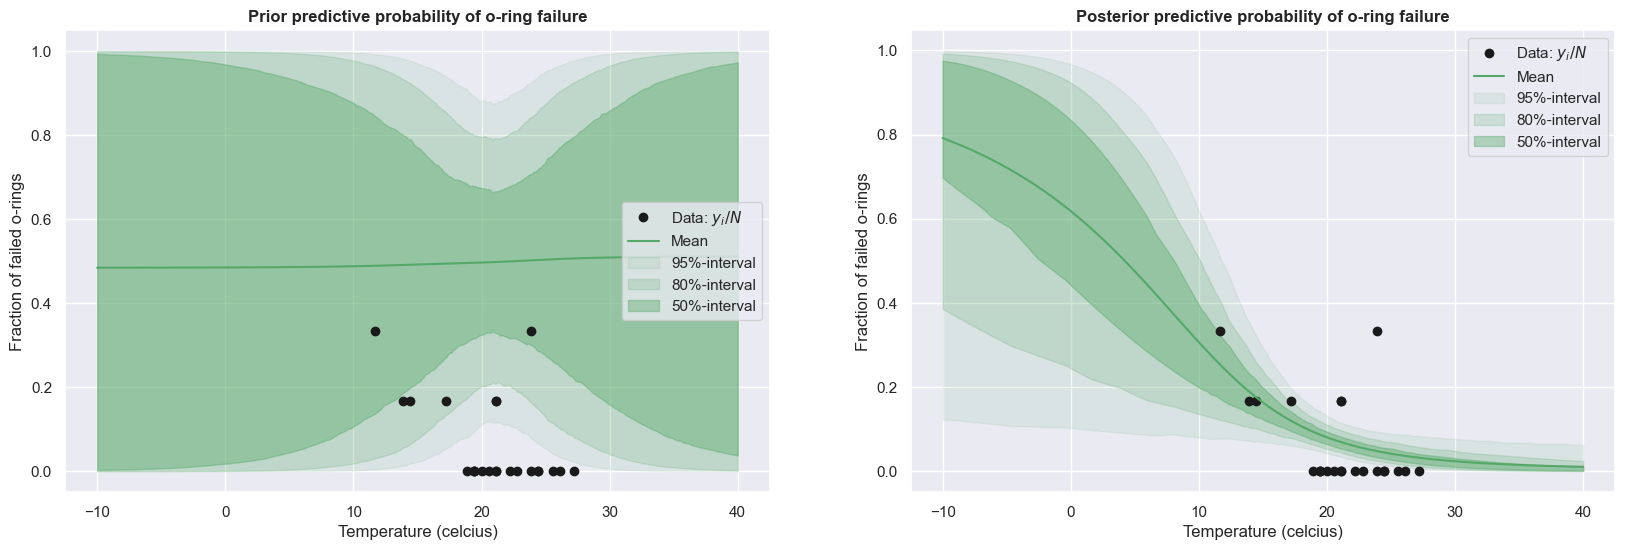

In [37]:
# set seed for reproducibility
seed = 0
key = random.PRNGKey(seed)

# Set up the logistic regression model and grid approximations for prior and posterior
# Inputs:
#   x, y, N: observed data (features, outcomes, number of trials)
#   sigma2_alpha, sigma2_beta: prior variances for alpha and beta
#   alphas, betas: grid points for alpha and beta (1D arrays)
# Outputs:
#   model: LogisticRegression object
#   post_approx: GridApproximation2D object for posterior
#   prior_approx: GridApproximation2D object for prior
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# Create a figure with 2 subplots (prior and posterior), size 20x6
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
# Plot observed data on both subplots (counts=False means plotting fraction of failures)
plot_data(ax[0], counts=False)
plot_data(ax[1], counts=False)

# Number of (alpha, beta) samples to draw from each distribution for uncertainty quantification
num_samples = 2000

# Loop over both prior and posterior grid approximations for visualization
for idx_plot, dist in enumerate([prior_approx, post_approx]):
    # Split the random key for reproducible sampling
    key, subkey = random.split(key)

    # Draw samples from the grid approximation
    # Function: dist.sample(subkey, num_samples)
    # Inputs:
    #   subkey: JAX PRNG key
    #   num_samples: number of samples to draw
    # Outputs:
    #   alpha_samples: shape (num_samples, 1)
    #   beta_samples: shape (num_samples, 1)
    alpha_samples, beta_samples = dist.sample(subkey, num_samples)

    # Compute predicted probabilities theta(x) for each sample and each temperature
    # Function: model.theta(x_pred, alpha_samples, beta_samples)
    # Inputs:
    #   x_pred: standardized temperatures, shape (num_points,)
    #   alpha_samples, beta_samples: shape (num_samples, 1)
    # Output:
    #   theta_samples: shape (num_samples, num_points)
    theta_samples = model.theta(x_pred, alpha_samples, beta_samples)

    # Compute posterior mean of theta(x) at each temperature
    # Equation: mean = average over samples, axis=0
    # Output shape: (num_points,)
    theta_mean = theta_samples.mean(0)

    # Compute 95% credibility interval for theta(x) at each temperature
    # Function: jnp.quantile
    # Inputs:
    #   theta_samples: (num_samples, num_points)
    #   q: quantile (0.025 for lower, 0.975 for upper)
    #   axis=0: compute quantile across samples for each temperature
    # Outputs:
    #   theta_lower, theta_upper: shape (num_points,)
    theta_lower = jnp.quantile(theta_samples, 0.025, axis=0)
    theta_upper = jnp.quantile(theta_samples, 0.975, axis=0)

    # Plot the posterior mean probability curve
    # x-axis: temp_pred (original temperature scale), y-axis: theta_mean
    ax[idx_plot].plot(temp_pred, theta_mean, 'g-', label='Mean')

    # Plot shaded credibility intervals for different interval sizes (95%, 80%, 50%)
    # For each interval, compute lower and upper quantiles and fill between them
    for interval_size, b in [(0.95, 0.1), (0.8, 0.2), (0.5, 0.4)]:
        c = 1 - interval_size
        # Lower and upper quantiles for the interval
        theta_lower = jnp.quantile(theta_samples, c/2, axis=0)
        theta_upper = jnp.quantile(theta_samples, 1-c/2, axis=0)
        # Fill between lower and upper bounds for the interval
        ax[idx_plot].fill_between(
            temp_pred, theta_lower, theta_upper,
            color='g', alpha=b, label=f'{interval_size*100:2.0f}%-interval'
        )

    # Add legend and title for each subplot
    ax[idx_plot].legend()
    ax[idx_plot].set_title(f'{dist.name} predictive probability of o-ring failure', fontweight='bold')

# 
# Summary of shapes and functions used:
# - dist.sample(key, num_samples): returns (num_samples, 1) arrays for alpha and beta
# - model.theta(x_pred, alpha_samples, beta_samples): returns (num_samples, len(temp_pred))
# - jnp.mean(..., axis=0): mean over samples, shape (len(temp_pred),)
# - jnp.quantile(..., q, axis=0): quantile over samples, shape (len(temp_pred),)
# - ax.plot(...): plots mean curve
# - ax.fill_between(...): plots shaded intervals for uncertainty

**Task 5.5**: Compute and plot the posterior mean and a 95% credibility interval for the probability of obtaining at least one failure among the 6 o-rings

**Solution**

Text(0.5, 1.0, 'Posterior predictive probability of at least one o-ring failure')

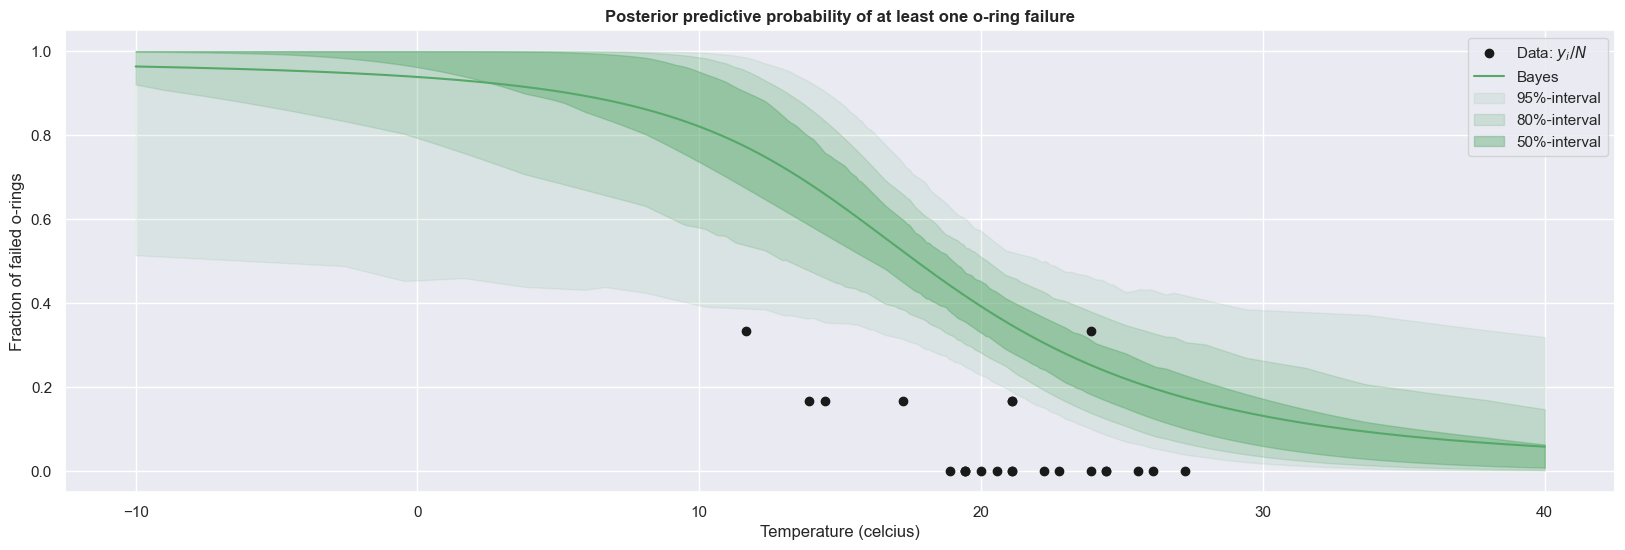

In [38]:
# set seed and number of samples for reproducibility and uncertainty quantification
seed = 0
key = random.PRNGKey(seed)
num_samples = 2000  # Number of posterior samples to draw

# Set up the logistic regression model and posterior grid approximation
# Inputs:
#   x, y, N: observed data (features, outcomes, number of trials)
#   sigma2_alpha, sigma2_beta: prior variances for alpha and beta
#   alphas, betas: grid points for alpha and beta (1D arrays)
# Outputs:
#   model: LogisticRegression object
#   post_approx: GridApproximation2D object for posterior
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')

# Draw samples of (alpha, beta) from the posterior grid approximation
# Inputs:
#   key: JAX PRNG key
#   num_samples: number of samples to draw
# Outputs:
#   alpha_samples: shape (num_samples, 1)
#   beta_samples: shape (num_samples, 1)
alpha_samples, beta_samples = post_approx.sample(key, num_samples)

# Compute predicted probabilities theta(x) for each sample and each temperature
# Function: model.theta(x_pred, alpha_samples, beta_samples)
# Inputs:
#   x_pred: standardized temperatures, shape (num_points,)
#   alpha_samples, beta_samples: shape (num_samples, 1)
# Output:
#   theta_samples: shape (num_samples, num_points)
theta_samples = model.theta(x_pred, alpha_samples, beta_samples)

# Compute the probability of at least one failure for each sample and temperature
# For a Binomial(n, p), the probability of at least one failure is:
#   P(y >= 1) = 1 - P(y = 0) = 1 - (1 - p)^n
# Inputs:
#   theta_samples: (num_samples, num_points)
#   N_pred: scalar (number of o-rings per prediction, e.g., 6)
# Output:
#   prob_at_least_one_failure: (num_samples, num_points)
prob_at_least_one_failure = 1 - (1 - theta_samples) ** N_pred

# Compute the posterior mean and 95% credibility interval for the probability of at least one failure
# Mean: average over samples for each temperature
# Lower/Upper: 2.5% and 97.5% quantiles over samples for each temperature
# Inputs:
#   prob_at_least_one_failure: (num_samples, num_points)
# Outputs:
#   post_mean: (num_points,)
#   post_lower: (num_points,)
#   post_upper: (num_points,)
post_mean = prob_at_least_one_failure.mean(0)
post_lower = jnp.quantile(prob_at_least_one_failure, 0.025, axis=0)
post_upper = jnp.quantile(prob_at_least_one_failure, 0.975, axis=0)

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
# Plot the observed data (fraction of failures) for reference
plot_data(ax, counts=False)

# Plot the posterior mean probability curve for at least one failure
# x-axis: temp_pred (original temperature scale), y-axis: post_mean
ax.plot(temp_pred, post_mean, 'g-', label='Bayes')

# Plot shaded credibility intervals for different interval sizes (95%, 80%, 50%)
# For each interval, compute lower and upper quantiles and fill between them
for interval_size, b in [(0.95, 0.1), (0.8, 0.2), (0.5, 0.4)]:
    c = 1 - interval_size
    # Lower and upper quantiles for the interval
    post_lower = jnp.quantile(prob_at_least_one_failure, c/2, axis=0)
    post_upper = jnp.quantile(prob_at_least_one_failure, 1-c/2, axis=0)
    # Fill between lower and upper bounds for the interval
    ax.fill_between(
        temp_pred, post_lower, post_upper,
        color='g', alpha=b, label=f'{interval_size*100:2.0f}%-interval'
    )

# Add legend and title for the plot
ax.legend()
ax.set_title(f'{post_approx.name} predictive probability of at least one o-ring failure', fontweight='bold')

# ---------------------------------------------------------------
# Summary of shapes and equations:
# - alpha_samples, beta_samples: (num_samples, 1)
# - theta_samples: (num_samples, num_points)
# - prob_at_least_one_failure: (num_samples, num_points)
# - post_mean, post_lower, post_upper: (num_points,)
# - Equation: P(y* >= 1 | x*) = 1 - (1 - theta(x*))^N_pred
# - For each temperature, the mean and intervals summarize posterior uncertainty

**End of solution**